# DSCI 552 Homework 4

Name: Ziyue Chen

Github Username: zic115

USC ID: 8823457220

# 1. Time Series Classification Part 1: Feature Creation/Extraction

In [1]:
# Import packages
import pandas as pd
import numpy as np
from scipy.stats import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

import statsmodels.api as sm

!pip install imblearn
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## 1. (b) Split train and test data

In [2]:
# Generate file paths
folders = {'bending1': 7,
           'bending2': 6,
           'cycling': 15,
           'lying': 15,
           'sitting': 15,
           'standing': 15,
           'walking': 15}

paths = []
for folder in folders:
    for file in range(1, folders[folder] + 1):
        path = '../data/AReM/' + folder + '/dataset' + str(file) + '.csv'
        paths.append(path)

In [3]:
# Split train and test paths
test_paths = ['../data/AReM/bending1/dataset1.csv',
              '../data/AReM/bending1/dataset2.csv',
              '../data/AReM/bending2/dataset1.csv',
              '../data/AReM/bending2/dataset2.csv',
              '../data/AReM/cycling/dataset1.csv',
              '../data/AReM/cycling/dataset2.csv',
              '../data/AReM/cycling/dataset3.csv',
              '../data/AReM/lying/dataset1.csv',
              '../data/AReM/lying/dataset2.csv',
              '../data/AReM/lying/dataset3.csv',
              '../data/AReM/sitting/dataset1.csv',
              '../data/AReM/sitting/dataset2.csv',
              '../data/AReM/sitting/dataset3.csv',
              '../data/AReM/standing/dataset1.csv',
              '../data/AReM/standing/dataset2.csv',
              '../data/AReM/standing/dataset3.csv',
              '../data/AReM/walking/dataset1.csv',
              '../data/AReM/walking/dataset2.csv',
              '../data/AReM/walking/dataset3.csv']

train_paths = []
for i in range(len(paths)):
    if paths[i] not in test_paths:
        train_paths.append(paths[i])

In [4]:
# Generate train set
train = None
for path in train_paths:
    df = pd.read_csv(path, skiprows = 4)
    if 'bending' in path:
        df['activity'] = 'bending'
    else:
        df['activity'] = 'other'
    train = pd.concat([train, df])
    
train = train.reset_index(drop = True)
train

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                    0      42.00       0.71      21.25       0.43      30.00   
1                  250      41.50       0.50      20.25       1.48      31.25   
2                  500      41.50       0.50      14.25       1.92      33.00   
3                  750      40.75       0.83      15.75       0.43      33.00   
4                 1000      40.00       0.71      20.00       2.74      32.75   
...                ...        ...        ...        ...        ...        ...   
33114           118750      34.50       6.18       9.00       3.56      12.67   
33115           119000      25.75       6.02      13.75       2.05      16.00   
33116           119250      31.50       3.35      10.25       5.12      16.25   
33117           119500      33.75       2.77      14.00       3.24      13.75   
33118           119750      37.00       1.41      18.25       3.70      11.00   

       var_rss23 activity  
0           0.00  bending  
1           1.09  bending  
2           0.00  bending  
3           0.00  bending  
4           0.43  bending  
...          ...      ...  
33114       4.19    other  
33115       1.58    other  
33116       2.95    other  
33117       0.43    other  
33118       4.32    other  

[33119 rows x 8 columns]

In [5]:
# Generate test set
test = None
for path in test_paths:
    df = pd.read_csv(path, skiprows = 4)
    if 'bending' in path:
        df['activity'] = 'bending'
    else:
        df['activity'] = 'other'
    test = pd.concat([test, df])
    
test = test.reset_index(drop = True)
test

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                   0      39.25       0.43      22.75       0.43      33.75   
1                 250      39.25       0.43      23.00       0.00      33.00   
2                 500      39.25       0.43      23.25       0.43      33.00   
3                 750      39.50       0.50      23.00       0.71      33.00   
4                1000      39.50       0.50      24.00       0.00      33.00   
...               ...        ...        ...        ...        ...        ...   
9115           118750      36.00       2.45      17.00       5.10      20.50   
9116           119000      34.33       1.89      15.00       2.45      17.00   
9117           119250      33.00       7.35      14.60       3.14      13.00   
9118           119500      31.67       1.25      11.00       6.16      19.25   
9119           119750      30.75      10.21      11.75       1.09      18.50   

      var_rss23 activity  
0          1.30  bending  
1          0.00  bending  
2          0.00  bending  
3          0.00  bending  
4          0.00  bending  
...         ...      ...  
9115       0.87    other  
9116       2.12    other  
9117       5.70    other  
9118       2.17    other  
9119       3.20    other  

[9120 rows x 8 columns]

## 1. (c) Feature extraction

### 1. (c) i. Time-domain features that are usually used in time series classification

Some common features are minimum, maximum, mean, standard deviation, and skewness.

### 1. (c) ii. Extract the time-domain features for all of the 6 time series in each instance

In [6]:
# Define a function for extraction
def extractFeatures(df, instance):
    data = {'Instance': [instance]}
    time_series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    
    for i in range(len(time_series)):
        curr = time_series[i]
        minimum = df[curr].min()
        maximum = df[curr].max()
        mean = df[curr].mean()
        median = df[curr].median()
        std = df[curr].std()
        q1 = df[curr].quantile(0.25)
        q3 = df[curr].quantile(0.75)
        
        curr_data = {'Min_' + str(i + 1): [minimum],
                     'Max_' + str(i + 1): [maximum],
                     'Mean_' + str(i + 1): [mean],
                     'Median_' + str(i + 1): [median],
                     'Std_' + str(i + 1): [std],
                     'Q1_' + str(i + 1): [q1],
                     'Q3_' + str(i + 1): [q3]}
        data = data | curr_data

    stats = pd.DataFrame(data)
    return stats

In [7]:
# Extract features from each instance
instances = None
for i in range(len(paths)):
    df = pd.read_csv(paths[i], skiprows = 4)
    stats = extractFeatures(df, i + 1)
    if paths[i] in train_paths:
        stats['type'] = 'train'
        if 'bending' in paths[i]:
            stats['activity'] = 'bending'
        else:
            stats['activity'] = 'other'
    else:
        stats['type'] = 'test'
        if 'bending' in paths[i]:
            stats['activity'] = 'bending'
        else:
            stats['activity'] = 'other'
    instances = pd.concat([instances, stats])

instances = instances.reset_index(drop = True)
instances

Instance  Min_1  Max_1     Mean_1  Median_1     Std_1   Q1_1     Q3_1  \
0          1  37.25  45.00  40.624792     40.50  1.476967  39.25  42.0000   
1          2  38.00  45.67  42.812812     42.50  1.435550  42.00  43.6700   
2          3  35.00  47.40  43.954500     44.33  1.558835  43.00  45.0000   
3          4  33.00  47.75  42.179813     43.50  3.670666  39.15  45.0000   
4          5  33.00  45.75  41.678063     41.75  2.243490  41.33  42.7500   
..       ...    ...    ...        ...       ...       ...    ...      ...   
83        84  19.50  45.33  33.586875     34.25  4.650935  30.25  37.0000   
84        85  19.75  45.50  34.322750     35.25  4.752477  31.00  38.0000   
85        86  19.50  46.00  34.546229     35.25  4.842294  31.25  37.8125   
86        87  23.50  46.25  34.873229     35.25  4.531720  31.75  38.2500   
87        88  19.25  44.00  34.473188     35.00  4.796705  31.25  38.0000   

    Min_2  Max_2  ...   Q3_5  Min_6  Max_6    Mean_6  Median_6     Std_6  \
0     0.0   1.30  ...  36.00   0.00   1.92  0.570583      0.43  0.582915   
1     0.0   1.22  ...  34.50   0.00   3.11  0.571083      0.43  0.601010   
2     0.0   1.70  ...  36.50   0.00   1.79  0.493292      0.43  0.513506   
3     0.0   3.00  ...  36.33   0.00   2.18  0.613521      0.50  0.524317   
4     0.0   2.83  ...  31.25   0.00   1.79  0.383292      0.43  0.389164   
..    ...    ...  ...    ...    ...    ...       ...       ...       ...   
83    0.0  14.67  ...  18.25   0.00   8.32  3.259729      3.11  1.640243   
84    0.0  13.47  ...  17.75   0.00   9.67  3.432562      3.20  1.732727   
85    0.0  12.47  ...  17.75   0.00  10.00  3.338125      3.08  1.656742   
86    0.0  14.82  ...  18.00   0.00   9.51  3.424646      3.27  1.690960   
87    0.0  13.86  ...  17.75   0.43   9.00  3.340458      3.09  1.699114   

      Q1_6    Q3_6   type  activity  
0   0.0000  1.3000   test   bending  
1   0.0000  1.3000   test   bending  
2   0.0000  0.9400  train   bending  
3   0.0000  1.0000  train   bending  
4   0.0000  0.5000  train   bending  
..     ...     ...    ...       ...  
83  2.0500  4.3225  train     other  
84  2.1575  4.5650  train     other  
85  2.1600  4.3350  train     other  
86  2.1700  4.5000  train     other  
87  2.1200  4.3750  train     other  

[88 rows x 45 columns]

### 1. (c) iii. Standard deviation of each of the time-domain features

In [8]:
# Calculate the standard deviations
columns = list(instances.columns[1:-2])
stds = None
for col in columns:
    std = instances[col].std()
    stats = pd.DataFrame({'Std': [std]}).rename(index = {0: col})
    stds = pd.concat([stds, stats])

stds

Std
Min_1     9.569975
Max_1     4.394362
Mean_1    5.335718
Median_1  5.440054
Std_1     1.772153
Q1_1      6.153590
Q3_1      5.138925
Min_2     0.000000
Max_2     5.062729
Mean_2    1.574164
Median_2  1.412244
Std_2     0.884105
Q1_2      0.946386
Q3_2      2.125266
Min_3     2.956462
Max_3     4.875137
Mean_3    4.008380
Median_3  4.036396
Std_3     0.946710
Q1_3      4.220658
Q3_3      4.171628
Min_4     0.000000
Max_4     2.183625
Mean_4    1.166114
Median_4  1.145586
Std_4     0.458242
Q1_4      0.843620
Q3_4      1.552504
Min_5     6.124001
Max_5     5.741238
Mean_5    5.675593
Median_5  5.813782
Std_5     1.024898
Q1_5      6.096465
Q3_5      5.531720
Min_6     0.045838
Max_6     2.518921
Mean_6    1.154812
Median_6  1.086474
Std_6     0.517617
Q1_6      0.758584
Q3_6      1.523599

In [9]:
# Build a 90% bootsrap confidence interval for the standard deviation of each feature
for col in columns:
    data = (instances[col], )
    CI = bootstrap(data, np.std, confidence_level = 0.9, method = 'basic')
    print(col + ':', CI.confidence_interval)

Min_1: ConfidenceInterval(low=8.330774731521505, high=10.814431291630308)
Max_1: ConfidenceInterval(low=3.478276547672455, high=5.422576262120862)
Mean_1: ConfidenceInterval(low=4.754943270371594, high=5.943543619924074)
Median_1: ConfidenceInterval(low=4.86523866989738, high=6.06575853945401)
Std_1: ConfidenceInterval(low=1.5813077379804301, high=1.9642577187011998)
Q1_1: ConfidenceInterval(low=5.629406180254838, high=6.69244726160643)
Q3_1: ConfidenceInterval(low=4.392659193295393, high=5.921724337708496)
Min_2: ConfidenceInterval(low=0.0, high=0.0)
Max_2: ConfidenceInterval(low=4.693505234896843, high=5.460138561591562)
Mean_2: ConfidenceInterval(low=1.4334856284822406, high=1.7424050429145337)
Median_2: ConfidenceInterval(low=1.271083322365484, high=1.577631590653975)
Std_2: ConfidenceInterval(low=0.8219579793314689, high=0.9604720842109422)
Q1_2: ConfidenceInterval(low=0.852924533847552, high=1.054220555873779)
Q3_2: ConfidenceInterval(low=1.946474322858255, high=2.348974126024985

### 1. (c) iv. Select the three most important time-domain features

Three most important time-domain features can be max, mean, and median.

# 2. Time Series Classification Part 2: Binary and Multiclass Classification

## 2. (a) Binary classification using logistic regression

### 2. (a) i. Scatter plots of the features specified in 1. (c) iv. extracted from time series 1, 2, and 6 of each instance in the training set

In [10]:
# Generate training instances
train_instances = instances.loc[instances['type'] == 'train'].reset_index(drop = True)
train_instances

Instance  Min_1  Max_1     Mean_1  Median_1     Std_1   Q1_1     Q3_1  \
0          3  35.00  47.40  43.954500     44.33  1.558835  43.00  45.0000   
1          4  33.00  47.75  42.179813     43.50  3.670666  39.15  45.0000   
2          5  33.00  45.75  41.678063     41.75  2.243490  41.33  42.7500   
3          6  37.00  48.00  43.454958     43.25  1.386098  42.50  45.0000   
4          7  36.25  48.00  43.969125     44.50  1.618364  43.31  44.6700   
..       ...    ...    ...        ...       ...       ...    ...      ...   
64        84  19.50  45.33  33.586875     34.25  4.650935  30.25  37.0000   
65        85  19.75  45.50  34.322750     35.25  4.752477  31.00  38.0000   
66        86  19.50  46.00  34.546229     35.25  4.842294  31.25  37.8125   
67        87  23.50  46.25  34.873229     35.25  4.531720  31.75  38.2500   
68        88  19.25  44.00  34.473188     35.00  4.796705  31.25  38.0000   

    Min_2  Max_2  ...   Q3_5  Min_6  Max_6    Mean_6  Median_6     Std_6  \
0     0.0   1.70  ...  36.50   0.00   1.79  0.493292      0.43  0.513506   
1     0.0   3.00  ...  36.33   0.00   2.18  0.613521      0.50  0.524317   
2     0.0   2.83  ...  31.25   0.00   1.79  0.383292      0.43  0.389164   
3     0.0   1.58  ...  24.00   0.00   5.26  0.679646      0.50  0.622534   
4     0.0   1.50  ...  23.75   0.00   2.96  0.555313      0.49  0.487826   
..    ...    ...  ...    ...    ...    ...       ...       ...       ...   
64    0.0  14.67  ...  18.25   0.00   8.32  3.259729      3.11  1.640243   
65    0.0  13.47  ...  17.75   0.00   9.67  3.432562      3.20  1.732727   
66    0.0  12.47  ...  17.75   0.00  10.00  3.338125      3.08  1.656742   
67    0.0  14.82  ...  18.00   0.00   9.51  3.424646      3.27  1.690960   
68    0.0  13.86  ...  17.75   0.43   9.00  3.340458      3.09  1.699114   

      Q1_6    Q3_6   type  activity  
0   0.0000  0.9400  train   bending  
1   0.0000  1.0000  train   bending  
2   0.0000  0.5000  train   bending  
3   0.4300  0.8700  train   bending  
4   0.0000  0.8300  train   bending  
..     ...     ...    ...       ...  
64  2.0500  4.3225  train     other  
65  2.1575  4.5650  train     other  
66  2.1600  4.3350  train     other  
67  2.1700  4.5000  train     other  
68  2.1200  4.3750  train     other  

[69 rows x 45 columns]

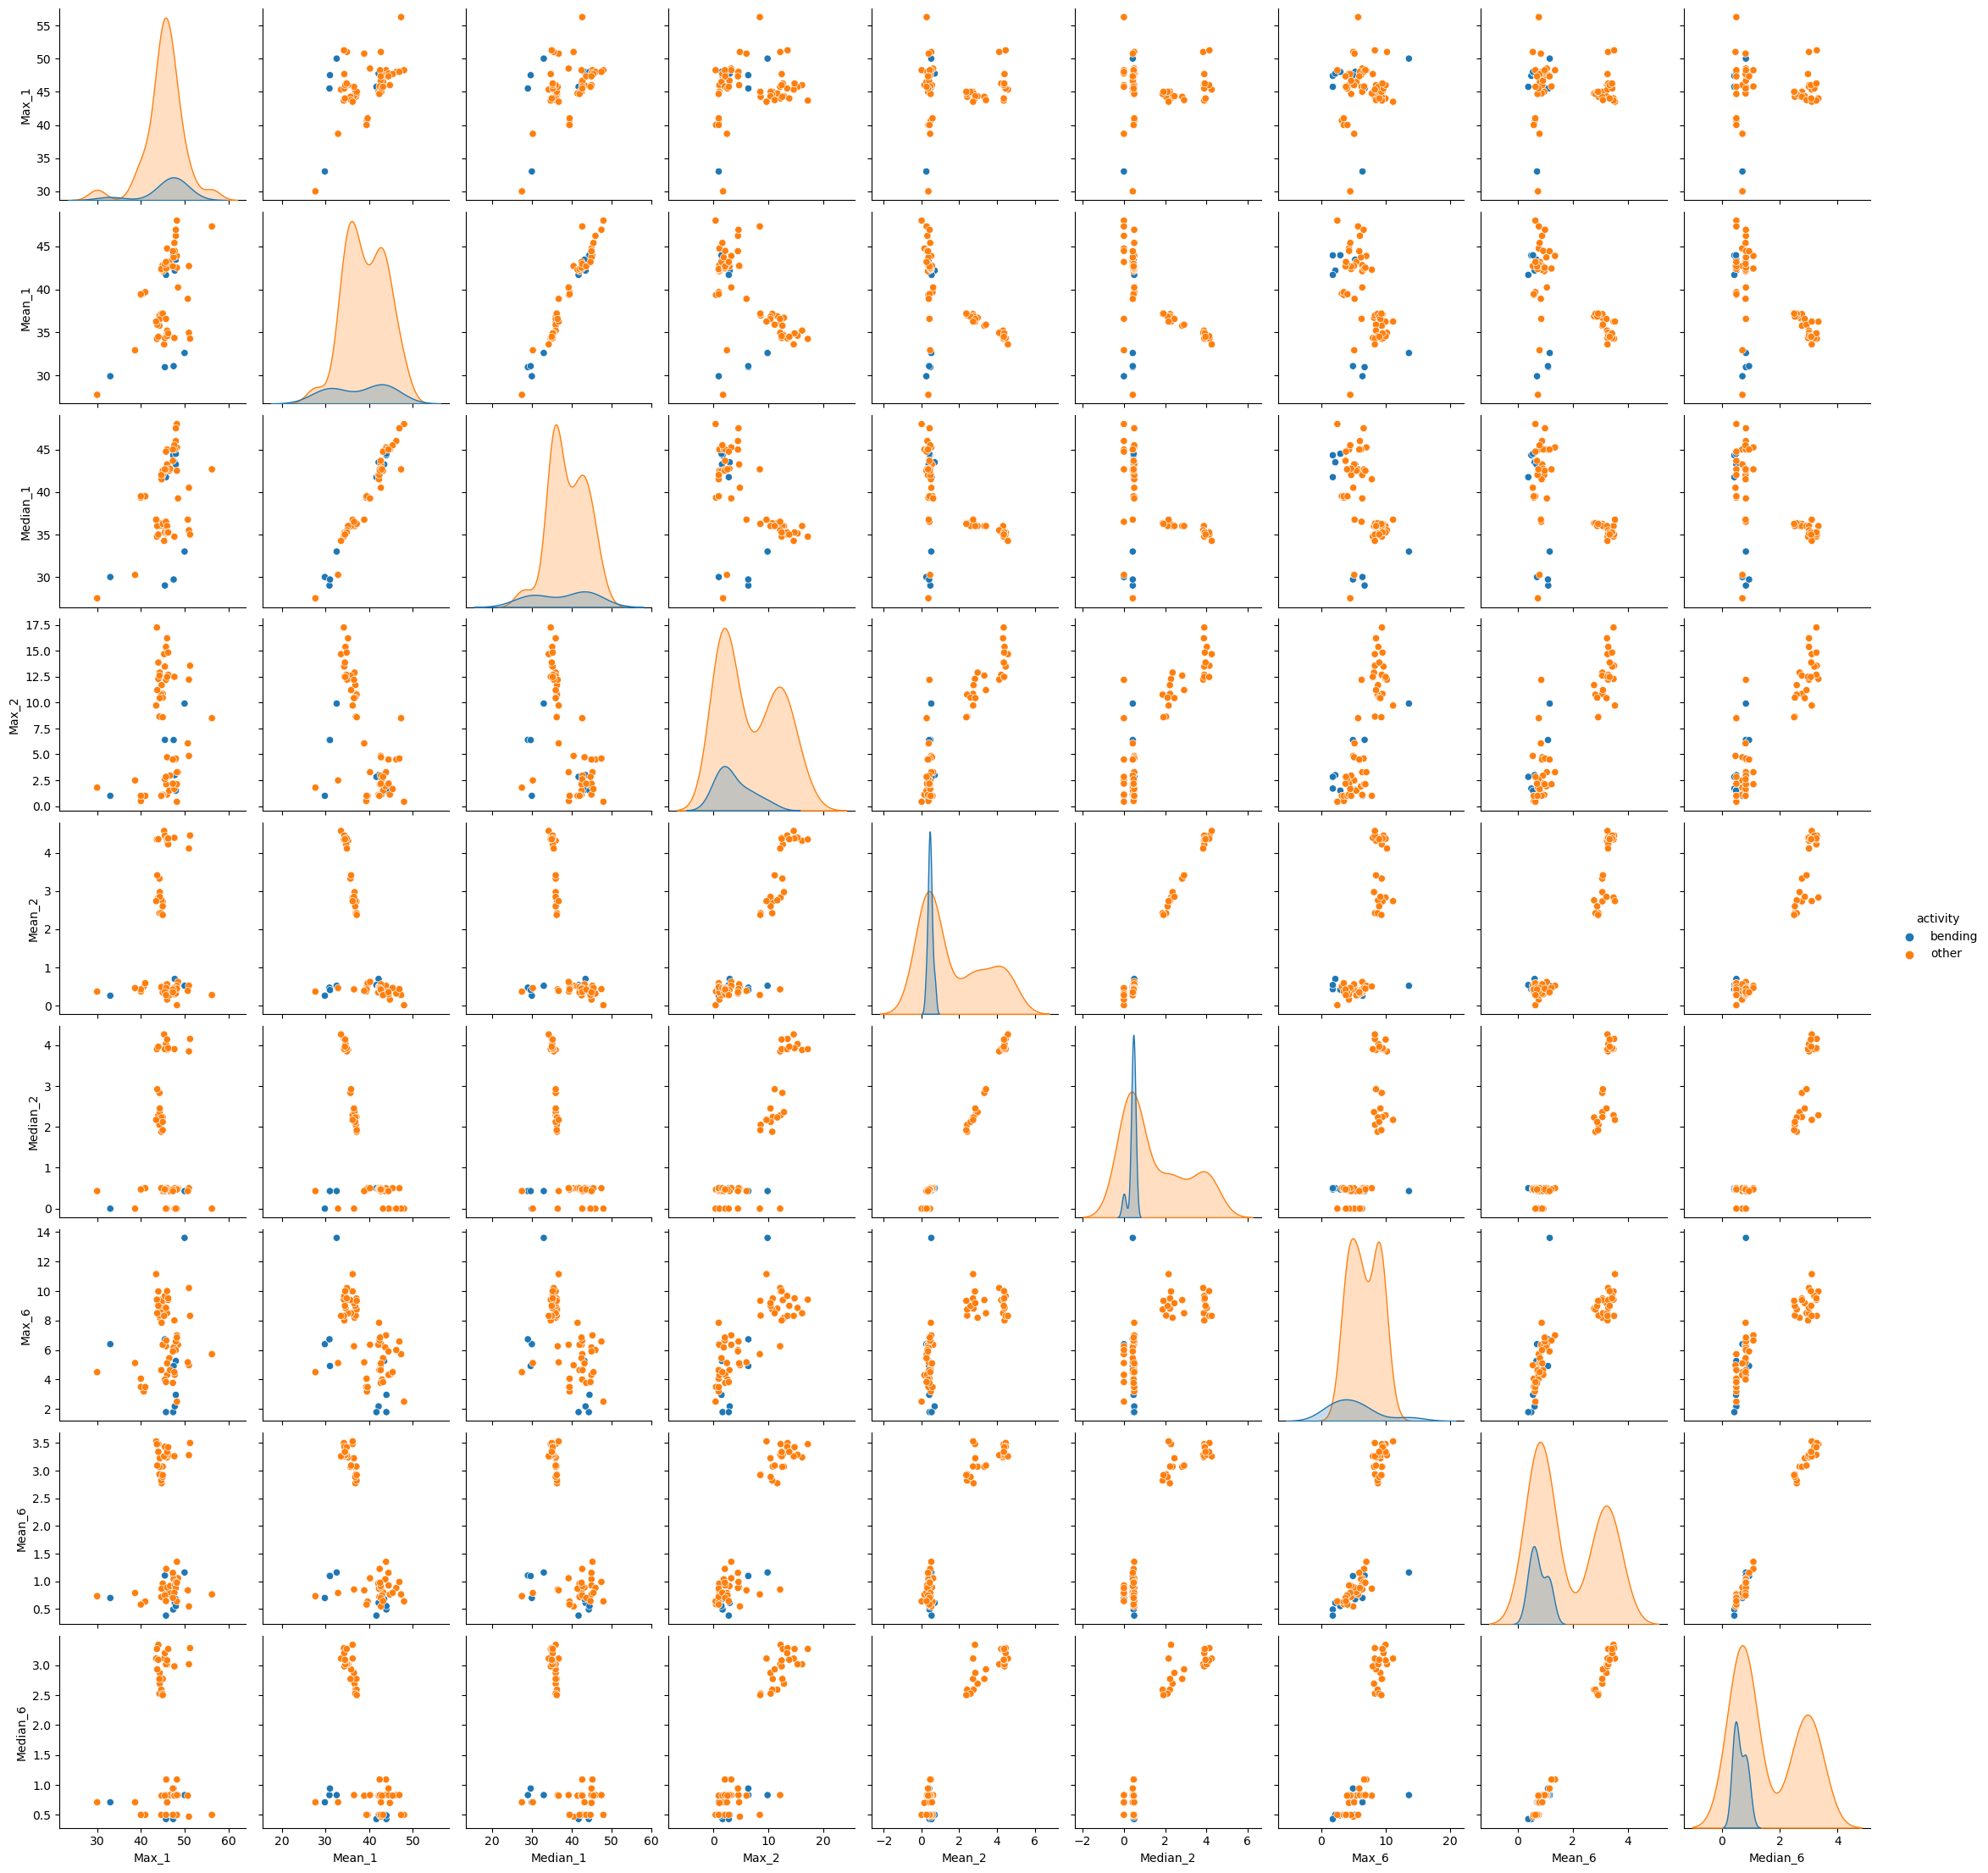

In [11]:
# Pairplot on selected features
features = ['Max_1', 'Mean_1', 'Median_1', 'Max_2', 'Mean_2', 'Median_2', 'Max_6', 'Mean_6', 'Median_6', 'activity']
sns.pairplot(train_instances[features], hue = 'activity')
plt.show()

### 2. (a) ii. Break each time series in the training set into two (approximately) equal length time series

In [12]:
# Defind a function for breaking time series
def breakTimeSeries(df, l):
    n = len(df)
    chunkLength = n // l
    remainder = n % l
    chunkLengths = [chunkLength] * l
    
    if remainder > 0:
        for i in range(remainder):
            chunkLengths[i] += 1
        
    res = None
    start = 0
    for i in range(len(chunkLengths)):
        chunk = df.iloc[start: start + chunkLengths[i]].drop(columns = ['# Columns: time']).reset_index(drop = True)
        chunk = chunk.rename(columns = {'avg_rss12': 'avg_rss12_chunk' + str(i + 1),
                                        'var_rss12': 'var_rss12_chunk' + str(i + 1),
                                        'avg_rss13': 'avg_rss13_chunk' + str(i + 1),
                                        'var_rss13': 'var_rss13_chunk' + str(i + 1),
                                        'avg_rss23': 'avg_rss23_chunk' + str(i + 1),
                                        'var_rss23': 'var_rss23_chunk' + str(i + 1)})
        res = pd.concat([res, chunk], axis = 1)
        start += chunkLengths[i]
    
    return res

In [13]:
# Define a function for extraction
def extractThreeFeatures(df, instance):
    data = {'Instance': [instance]}
    time_series = list(df.columns[:])
    
    for i in range(len(time_series)):
        curr = time_series[i]
        maximum = df[curr].max()
        mean = df[curr].mean()
        median = df[curr].median()
        
        curr_data = {'Max_' + str(i + 1): [maximum],
                     'Mean_' + str(i + 1): [mean],
                     'Median_' + str(i + 1): [median],}
        data = data | curr_data

    stats = pd.DataFrame(data)
    return stats

In [14]:
# Extract features from each training instance
train_instances_with_break = None
for i in range(len(train_paths)):
    df = pd.read_csv(train_paths[i], skiprows = 4)
    df = breakTimeSeries(df, 2)
    stats = extractThreeFeatures(df, paths.index(train_paths[i]) + 1)
    if 'bending' in train_paths[i]:
        stats['activity'] = 'bending'
    else:
        stats['activity'] = 'other'
    train_instances_with_break = pd.concat([train_instances_with_break, stats])

train_instances_with_break = train_instances_with_break.reset_index(drop = True)
train_instances_with_break

Instance  Max_1     Mean_1  Median_1  Max_2    Mean_2  Median_2  Max_3  \
0          3  46.50  44.057167    44.500   1.50  0.381042     0.470  29.25   
1          4  47.75  43.278875    45.000   3.00  0.673292     0.485  30.00   
2          5  45.75  41.621208    42.330   2.83  0.623083     0.500  28.25   
3          6  48.00  44.117042    45.000   1.30  0.250042     0.000  27.00   
4          7  45.00  43.486208    43.710   1.30  0.378667     0.470  26.33   
..       ...    ...        ...       ...    ...       ...       ...    ...   
64        84  45.00  33.334500    34.000  11.78  4.408083     4.195  22.75   
65        85  44.50  34.036750    34.415  13.47  4.778292     4.030  22.00   
66        86  43.33  34.033875    35.000  12.47  4.574625     4.470  22.67   
67        87  44.00  34.920792    35.330  14.82  4.177958     3.865  24.25   
68        88  44.00  34.916792    35.375  13.86  4.262333     3.850  21.00   

       Mean_3  Median_3  ...  Max_10   Mean_10  Median_10  Max_11    Mean_11  \
0   23.096792    24.000  ...    4.44  0.501167       0.43   38.25  34.883375   
1   23.141250    23.750  ...    5.15  1.171792       0.87   38.50  30.965708   
2   19.081458    19.500  ...    2.35  0.568667       0.47   36.00  29.635833   
3   17.744167    18.000  ...    5.21  0.575708       0.43   26.00  22.850875   
4   16.397250    16.875  ...    3.56  0.669750       0.47   26.00  21.882042   
..        ...       ...  ...     ...       ...        ...     ...        ...   
64  15.445333    15.330  ...    9.00  3.183042       3.08   23.33  15.755958   
65  15.177083    15.250  ...    7.46  3.160375       2.95   23.25  15.520375   
66  15.340417    15.250  ...    8.22  3.031958       2.87   21.33  15.218417   
67  15.515875    15.500  ...    9.90  3.176250       2.95   23.50  15.939417   
68  15.335250    15.330  ...    8.38  3.128750       2.99   23.25  15.640917   

    Median_11  Max_12   Mean_12  Median_12  activity  
0      36.000    1.50  0.388333      0.000   bending  
1      30.415    2.18  0.586083      0.470   bending  
2      29.750    1.50  0.347500      0.430   bending  
3      23.250    4.06  0.543875      0.500   bending  
4      21.750    2.96  0.585750      0.500   bending  
..        ...     ...       ...        ...       ...  
64     15.875    8.32  3.290292      3.155     other  
65     15.750    9.67  3.321417      3.155     other  
66     15.000    8.64  3.432208      3.255     other  
67     16.000    9.51  3.418667      3.350     other  
68     16.000    8.26  3.241000      3.060     other  

[69 rows x 38 columns]

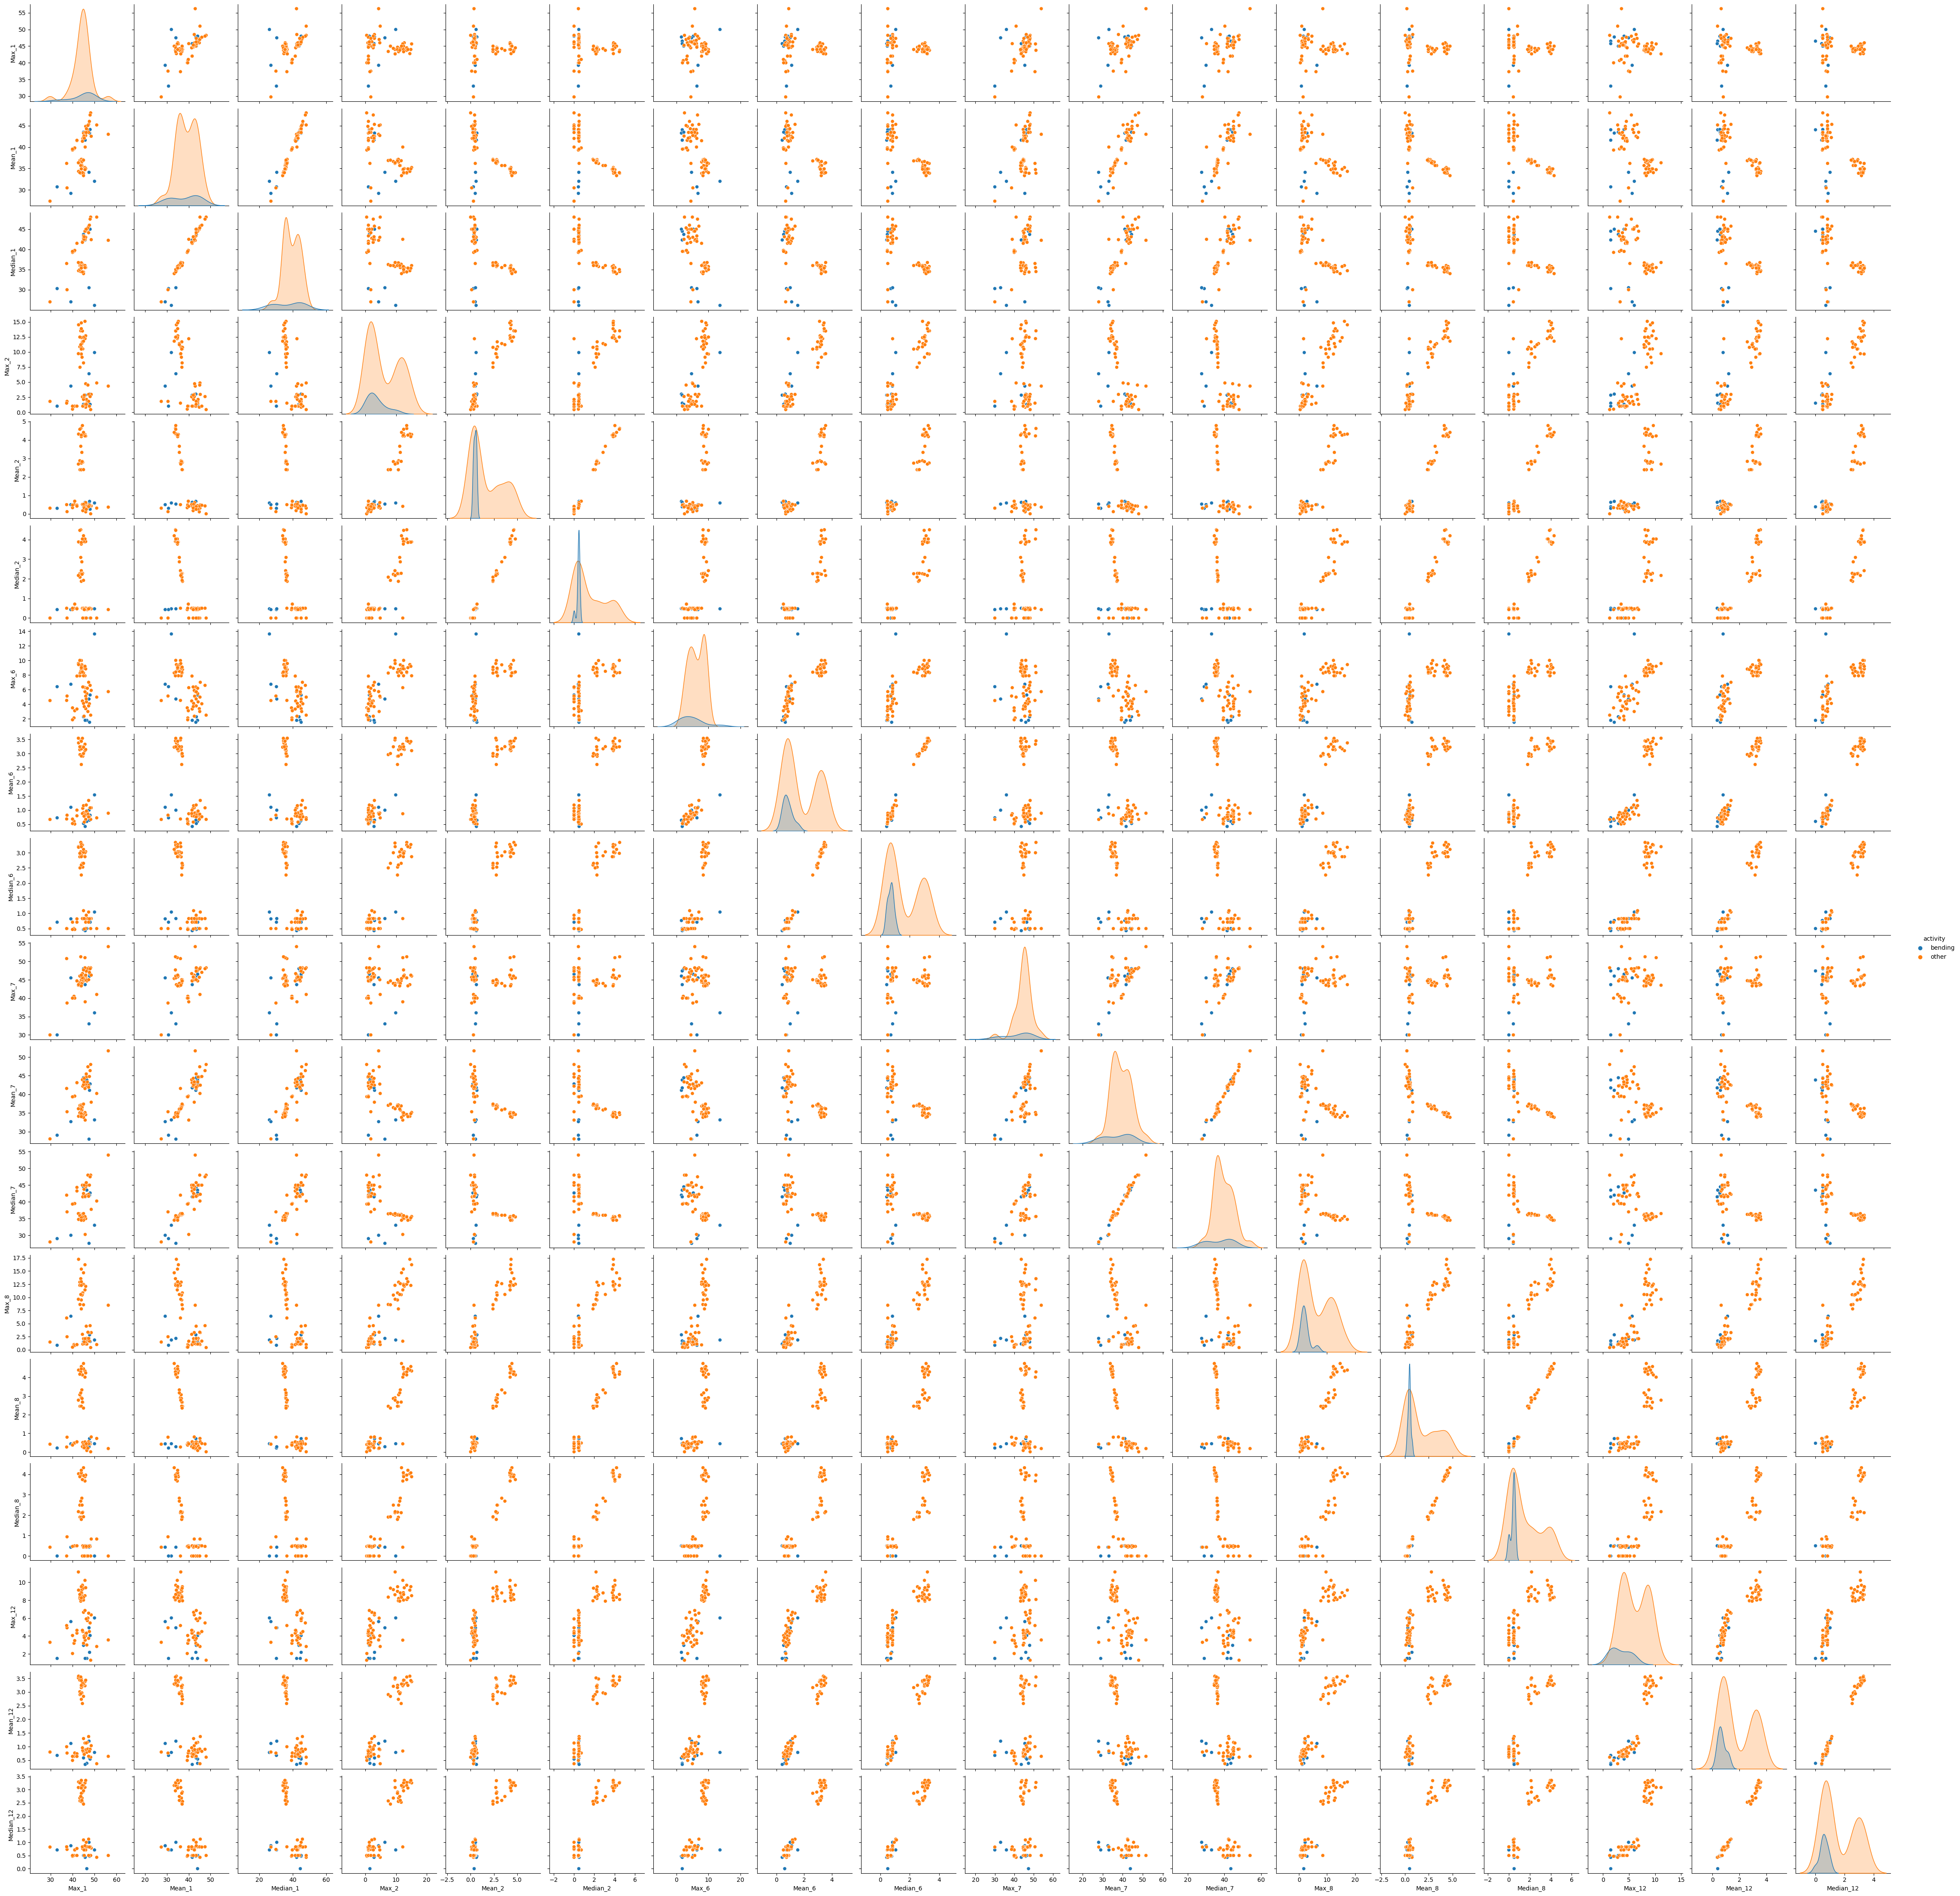

In [15]:
# Pairplot on selected features
features = ['Max_1', 'Mean_1', 'Median_1', 'Max_2', 'Mean_2', 'Median_2', 'Max_6', 'Mean_6', 'Median_6', 
            'Max_7', 'Mean_7', 'Median_7', 'Max_8', 'Mean_8', 'Median_8', 'Max_12', 'Mean_12', 'Median_12',
            'activity']
sns.pairplot(train_instances_with_break[features], hue = 'activity')
plt.show()

There seem to be no considerable differences in the results with those of 2.(a)i.

### 2. (a) iii. Break each time series in the training set into l ∈ {1, 2, . . . , 20} time series, use logistic regression, and find the best value of the pair (l, p)

In [16]:
# Define a function for extraction with different l
def breakAndExtract(paths, train_paths, l):
    train_instances_with_break = None
    for i in range(len(train_paths)):
        df = pd.read_csv(train_paths[i], skiprows = 4)
        df = breakTimeSeries(df, l)
        stats = extractThreeFeatures(df, paths.index(train_paths[i]) + 1)
        if 'bending' in train_paths[i]:
            stats['activity'] = 'bending'
        else:
            stats['activity'] = 'other'
        train_instances_with_break = pd.concat([train_instances_with_break, stats])

    train_instances_with_break = train_instances_with_break.reset_index(drop = True)
    return train_instances_with_break

In [17]:
# Fit a logistic regression model and use recursive feature elimination
cv_scores = []
pairs = []
l = 1
while l <= 20:
    train_instances_with_break = breakAndExtract(paths, train_paths, l)
    X_train = train_instances_with_break.iloc[:, 1:-1]
    y_train = train_instances_with_break['activity']
    
    model = LogisticRegression(C = float('inf'))
    rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
    rfecv = rfecv.fit(X_train, y_train)
    
    cv_score = max(rfecv.cv_results_['mean_test_score'])
    cv_scores.append(cv_score)
    
    p = rfecv.n_features_
    pairs.append((l, p))

    l += 1

In [18]:
# Find the best pair with the highest cv score
for i in range(len(cv_scores)):
    if cv_scores[i] == max(cv_scores):
        best_pair = pairs[i]
        break

print('best pair:', best_pair)

best pair: (2, 6)


In [19]:
# Get the pruned set of features using the best (l, p)
train_instances_with_break = breakAndExtract(paths, train_paths, best_pair[0])
X_train = train_instances_with_break.iloc[:, 1:-1]
y_train = train_instances_with_break['activity']
    
rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv = rfecv.fit(X_train, y_train)

selected = []
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        selected.append(X_train.columns[i])

print('selected features:', selected)

selected features: ['Max_1', 'Max_5', 'Mean_5', 'Median_5', 'Median_7', 'Max_12']


### 2. (a) iv. Report the confusion matrix, ROC, and AUC for the classifier on train data, and report the parameters of the logistic regression and the p-values associated with them

In [20]:
# Refit a logistic regression model
train_instances_with_break = pd.get_dummies(train_instances_with_break, columns = ['activity'], drop_first = True)
X_train_pruned = train_instances_with_break[selected]
X_train_pruned = sm.add_constant(X_train_pruned)
y_train = train_instances_with_break['activity_other']

log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train_pruned, y_train)

In [21]:
# Confusion matrix
y_train_pred = log_reg.predict(X_train_pruned)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[ 9  0]
 [ 0 60]]


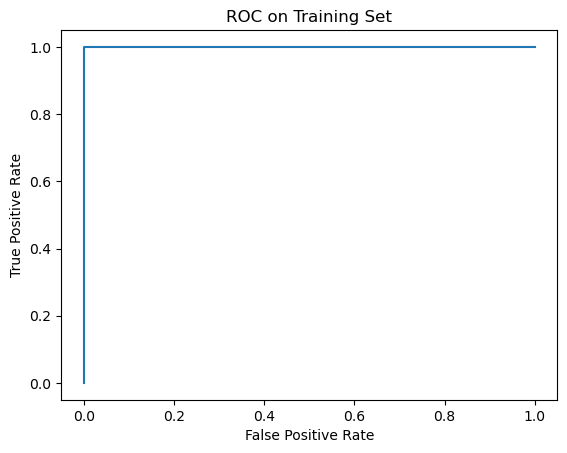

In [22]:
# ROC
y_train_pred_proba = log_reg.predict_proba(X_train_pruned)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
# AUC
auc_val = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val)

AUC: 1.0


In [24]:
# Parameters and p-values of the logistic regression
model = sm.Logit(y_train, X_train_pruned)
res = model.fit(method = 'lbfgs')
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.63507D+01

At iterate    1    f= -0.00000D+00    |proj g|=  5.83696D+00

At iterate    2    f= -0.00000D+00    |proj g|=  5.83696D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     24      2     0     0   5.837D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                           Logit Regression Results                   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


The parameters of the logistic regression are 0.6761 (Max_1), 0.2954 (Max_5), 0.1882 (Mean_5), 0.1909 (Median_5), 0.6110 (Median_7), 0.1010 (Max_12), and 0.0153 (constant). However, the model is unable to provide p-values and warns that there is a possibly complete quasi-separation. I think this happens because the dependent variable can be completely predicted by some of the selected features, but I'm not sure how to solve this problem.

### 2. (a) v. Test the classifier on the test set

In [25]:
# Generate test instances
test_instances_with_break = breakAndExtract(paths, test_paths, best_pair[0])
test_instances_with_break

Instance  Max_1     Mean_1  Median_1  Max_2    Mean_2  Median_2  Max_3  \
0          1  42.33  40.946958    41.250   1.22  0.375667     0.470  25.67   
1          2  44.25  42.643292    42.500   0.94  0.355000     0.470  25.33   
2          8  51.00  24.675375    24.330   6.87  0.774500     0.430  25.33   
3          9  31.33  29.071583    29.500   1.25  0.231208     0.000  24.00   
4         14  45.00  36.954208    36.000   8.18  2.392667     1.920  26.75   
5         15  44.75  37.592250    37.000   8.95  2.111625     1.715  24.00   
6         16  44.67  37.740667    36.710  12.99  2.147167     1.500  24.00   
7         29  29.75  27.368417    27.000   1.79  0.308042     0.000  13.25   
8         30  48.25  40.361042    48.000   3.11  0.194583     0.000  16.50   
9         31  48.25  48.001042    48.000   0.43  0.001792     0.000  13.00   
10        44  44.00  42.681292    42.585   1.12  0.365875     0.500  22.50   
11        45  50.75  45.811458    45.000   4.87  0.204167     0.000  24.00   
12        46  46.75  45.409875    45.250   1.00  0.260750     0.430  23.75   
13        59  48.00  46.127875    46.500   1.79  0.424542     0.470  18.75   
14        60  45.00  43.043292    43.500   2.12  0.500667     0.500  18.00   
15        61  46.50  44.447083    45.000   1.73  0.410458     0.470  19.25   
16        74  42.50  34.334833    35.750  12.19  3.974958     3.630  23.00   
17        75  45.00  33.762958    34.500  13.05  4.400833     3.920  23.75   
18        76  45.33  33.591625    34.250  12.53  4.573042     4.165  23.25   

       Mean_3  Median_3  ...  Max_10   Mean_10  Median_10  Max_11    Mean_11  \
0   17.672583    18.000  ...    5.50  1.076458      0.820   38.25  34.118375   
1   20.369667    21.000  ...    5.76  1.109250      0.830   38.50  32.301708   
2   18.648542    18.585  ...    6.76  0.858083      0.500   26.75  20.528208   
3   19.427625    19.875  ...    4.76  0.983792      0.710   33.00  16.720833   
4   17.121542    17.330  ...    7.83  2.826125      2.570   24.50  19.643917   
5   16.200708    16.500  ...    8.32  2.895750      2.760   24.33  19.774333   
6   16.472083    16.790  ...    9.74  3.081917      2.955   23.75  16.621667   
7    7.180500     7.250  ...    5.02  0.853500      0.765   17.00   6.472000   
8    6.908417     6.750  ...    3.20  0.455958      0.430   10.00   2.168750   
9    6.038958     6.000  ...    2.12  0.347417      0.430   12.00  10.124792   
10  17.484417    18.250  ...    5.36  0.672542      0.430   28.00  16.775708   
11  14.367542    16.250  ...    4.58  0.616000      0.430   22.00  18.325500   
12  14.046292    14.330  ...    6.36  1.086042      0.830   22.00  19.057458   
13  11.189167    12.000  ...    4.76  0.656125      0.470   18.25   9.403333   
14  13.437250    14.250  ...    6.56  0.736542      0.485   21.25  14.662583   
15  14.411167    15.125  ...    5.85  0.600250      0.430   21.25  14.721667   
16  15.919542    16.000  ...    8.86  3.373042      3.295   26.00  16.685375   
17  15.554458    15.750  ...    9.00  3.331625      3.090   24.25  16.749833   
18  15.481042    15.500  ...    8.58  3.084458      2.870   24.50  16.257417   

    Median_11  Max_12   Mean_12  Median_12  activity  
0      35.415    1.92  0.552167      0.430   bending  
1      32.000    3.11  0.533583      0.430   bending  
2      20.670    4.97  0.936917      0.810   bending  
3      16.500    6.76  1.473250      1.220   bending  
4      20.125    9.34  2.838083      2.450     other  
5      20.290    9.62  2.746417      2.335     other  
6      16.875    8.55  3.348542      3.270     other  
7       5.585    3.30  0.801083      0.820     other  
8       2.000    3.77  0.524500      0.470     other  
9      10.000    1.30  0.612333      0.500     other  
10     17.710    5.85  0.928792      0.600     other  
11     19.250    7.22  0.987000      0.710     other  
12     19.500    3.49  0.720083      0.710     other  
13      9.330    3.77  0.870042      0.820     other  
14     15.250    

In [26]:
# Test the model
test_instances_with_break = pd.get_dummies(test_instances_with_break, columns = ['activity'], drop_first = True)
X_test = test_instances_with_break[selected]
X_test = sm.add_constant(X_test)
y_test = test_instances_with_break['activity_other']

y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy on test set:', accuracy)
print('cross validation accuracy on training set:', max(cv_scores))

accuracy on test set: 1.0
cross validation accuracy on training set: 1.0


### 2. (a) vi. Instability in calculating logistic regression parameters?

Yes, the classes seem to be well-separated to cause instability as the statsmodel approach indicates a possibly complete quasi-separation and the p-values cannot be calculated.

### 2. (a) vii. Imbalanced classes?

Yes, it seems the classes are imbalanced as the number of class 0 (bending) is 9 and that of class 1 (other) is 60.

In [27]:
# Resample the data, fit a logistic regression model and use recursive feature elimination
cv_scores_resample = []
pairs_resample = []
best_cv_score = float('-inf')
l = 1
while l <= 20:
    train_instances_with_break = breakAndExtract(paths, train_paths, l)
    X_train = train_instances_with_break.iloc[:, 1:-1]
    y_train = train_instances_with_break['activity']
    
    oversample = SMOTE(random_state = 42)
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    model = LogisticRegression(C = float('inf'))
    rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
    rfecv = rfecv.fit(X_train, y_train)
    
    cv_score = max(rfecv.cv_results_['mean_test_score'])
    cv_scores_resample.append(cv_score)
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        selected_resample = []
        for i in range(len(rfecv.ranking_)):
            if rfecv.ranking_[i] == 1:
                selected_resample.append(X_train.columns[i])

    p = rfecv.n_features_
    pairs_resample.append((l, p))

    l += 1

In [28]:
# Find the best pair with the highest cv score
for i in range(len(cv_scores_resample)):
    if cv_scores_resample[i] == max(cv_scores_resample):
        best_pair_resample = pairs_resample[i]
        break

print('best pair:', best_pair_resample)

best pair: (9, 4)


In [29]:
# Get the pruned set of features using the best (l, p)
print('selected features:', selected_resample)

selected features: ['Max_5', 'Mean_17', 'Max_25', 'Max_48']


In [30]:
# Refit a logistic regression model
train_instances_with_break = pd.get_dummies(train_instances_with_break, columns = ['activity'], drop_first = True)
X_train_pruned = train_instances_with_break[selected_resample]
X_train_pruned = sm.add_constant(X_train_pruned)
y_train = train_instances_with_break['activity_other']

log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train_pruned, y_train)

In [31]:
# Confusion matrix of training set
y_train_pred = log_reg.predict(X_train_pruned)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[ 8  1]
 [ 1 59]]


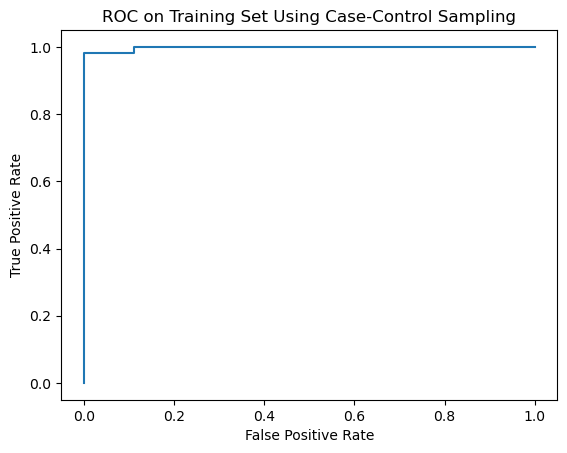

In [32]:
# ROC of training set
y_train_pred_proba = log_reg.predict_proba(X_train_pruned)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set Using Case-Control Sampling')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
# AUC of training set
auc_val = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val)

AUC: 0.9981481481481481


In [34]:
# Parameters and p-values of the logistic regression
model = sm.Logit(y_train, X_train_pruned)
res = model.fit(method = 'lbfgs')
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.57991D+01

At iterate    1    f=  2.05311D-15    |proj g|=  5.38043D+00

At iterate    2    f=  2.05311D-15    |proj g|=  5.38043D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     24      2     0     0   5.380D+00   2.053D-15
  F =   2.0531080861184780E-015

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                           Logit Regression Results                   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [35]:
# Generate test instances
test_instances_with_break = breakAndExtract(paths, test_paths, best_pair_resample[0])
test_instances_with_break

Instance  Max_1     Mean_1  Median_1  Max_2    Mean_2  Median_2  Max_3  \
0          1  41.75  40.537222    40.585   1.00  0.541852     0.500  24.00   
1          2  44.25  43.421296    43.500   0.94  0.557407     0.500  25.33   
2          8  24.75  21.010741    21.330   4.92  0.964259     0.820  24.75   
3          9  30.00  28.018333    27.000   0.94  0.109259     0.000  24.00   
4         14  44.50  36.597222    35.625   6.18  2.372222     2.145  24.00   
5         15  43.25  37.256111    36.750   7.08  2.128519     1.790  21.00   
6         16  44.00  37.765556    36.670  12.99  2.170370     1.500  24.00   
7         29  29.75  28.981481    29.000   0.50  0.134074     0.000   9.00   
8         30  30.00  28.950370    29.000   0.83  0.192963     0.000   9.50   
9         31  48.00  48.000000    48.000   0.00  0.000000     0.000   8.50   
10        44  42.25  41.986111    42.000   0.50  0.033148     0.000  19.33   
11        45  50.75  47.606481    48.000   4.87  0.346111     0.000  24.00   
12        46  46.67  45.478333    45.500   1.00  0.372963     0.430  21.00   
13        59  47.25  46.461296    46.500   0.83  0.435926     0.500  18.75   
14        60  45.00  42.820556    43.330   2.12  0.531111     0.500  18.00   
15        61  45.50  43.685370    44.500   1.73  0.448333     0.430  19.25   
16        74  41.33  34.724444    36.000  12.19  3.807037     3.600  21.33   
17        75  40.75  34.223148    35.415  11.08  4.429259     3.800  23.75   
18        76  41.33  32.806852    33.625  10.69  5.048148     5.310  20.75   

       Mean_3  Median_3  ...  Max_52   Mean_52  Median_52  Max_53    Mean_53  \
0   19.490741    19.710  ...    3.27  0.676981       0.50   37.75  31.542264   
1   19.714444    20.500  ...    5.72  1.688868       1.30   34.50  31.904340   
2   22.053333    22.125  ...    1.30  0.320000       0.43   23.75  21.136415   
3   18.817222    18.875  ...    4.64  1.000000       0.83   33.00  24.469811   
4   16.951296    17.500  ...    7.26  2.636038       2.45   23.50  19.961698   
5   15.586111    15.165  ...    7.69  3.007358       2.87   23.50  20.490377   
6   16.689815    17.375  ...    9.74  2.610943       2.05   20.67  15.690943   
7    6.971296     7.250  ...    4.61  1.049245       0.94   16.50  10.883774   
8    5.662037     6.000  ...    0.83  0.268113       0.43    4.00   1.834906   
9    6.034074     6.000  ...    1.58  0.467925       0.43   11.50  10.363208   
10  16.531481    16.625  ...    3.56  0.921132       0.71   28.00  17.708113   
11  18.327963    21.000  ...    4.58  1.136038       0.83   20.75  14.717736   
12  13.170741    13.125  ...    3.90  1.084717       0.94   22.00  20.438868   
13  13.023519    12.000  ...    4.76  0.726604       0.50   18.25  13.721509   
14  15.094074    15.290  ...    3.00  0.681887       0.47   18.33  15.702830   
15  11.009074    12.125  ...    2.95  0.448302       0.43   19.50  15.726226   
16  15.424444    15.875  ...    8.26  3.465283       2.92   24.00  16.080755   
17  16.105926    16.375  ...    7.40  3.872830       3.74   22.25  16.162453   
18  15.487593    15.500  ...    7.22  3.528491       3.43   22.33  16.479245   

    Median_53  Max_54   Mean_54  Median_54  activity  
0       31.00    1.50  0.402830       0.43   bending  
1       31.75    1.50  0.365472       0.43   bending  
2       21.25    1.25  0.608491       0.50   bending  
3       25.67    6.68  2.116038       1.50   bending  
4       20.67    8.17  2.716981       2.35     other  
5       21.00    8.83  2.280000       2.05     other  
6       16.25    8.50  3.992453       3.67     other  
7       10.50    3.30  0.955094       0.83     other  
8        2.00    1.25  0.436226       0.47     other  
9       10.50    1.22  0.699245       0.83     other  
10      17.75    5.79  1.049623       0.83     other  
11      15.75    7.22  1.833208       1.22     other  
12      20.75    1.30  0.433774       0.43     other  
13      15.25    3.27  0.881509       0.82     other  
14      16.00    

In [36]:
# Test the model
test_instances_with_break = pd.get_dummies(test_instances_with_break, columns = ['activity'], drop_first = True)
X_test = test_instances_with_break[selected_resample]
X_test = sm.add_constant(X_test)
y_test = test_instances_with_break['activity_other']

y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy on test set:', accuracy)

accuracy on test set: 1.0


In [37]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[ 4  0]
 [ 0 15]]


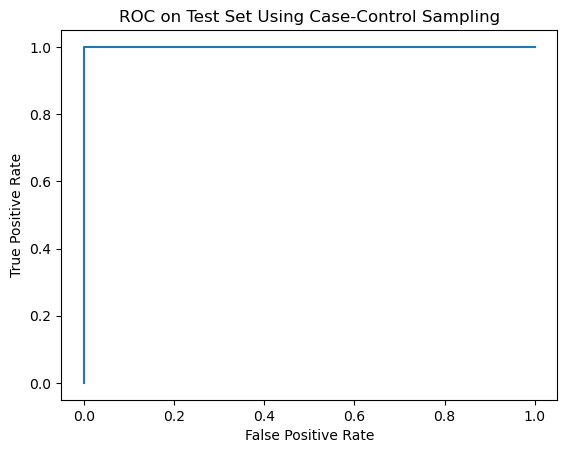

In [38]:
# ROC of test set
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Test Set Using Case-Control Sampling')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
# AUC of test set
auc_val = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_val)

AUC: 1.0


## 2. (b) Binary classification using L1-penalized logistic regression

### 2. (b) i. Repeat 2. (a) iii. using L1-penalized logistic regression

In [40]:
# Fit a L1-penalized logistic regression model and use recursive feature elimination
cv_scores_l1 = []
pairs_l1 = []
l = 1
while l <= 20:
    train_instances_with_break = breakAndExtract(paths, train_paths, l)
    X_train = train_instances_with_break.iloc[:, 1:-1]
    y_train = train_instances_with_break['activity']
    
    model = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'liblinear', refit = True, random_state = 42)
    rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
    rfecv = rfecv.fit(X_train, y_train)
    
    cv_score = max(rfecv.cv_results_['mean_test_score'])
    cv_scores_l1.append(cv_score)
    
    p = rfecv.n_features_
    pairs_l1.append((l, p))

    l += 1

In [41]:
# Find the best pair with the highest cv score
for i in range(len(cv_scores_l1)):
    if cv_scores_l1[i] == max(cv_scores_l1):
        best_pair_l1 = pairs_l1[i]
        break

print('best pair:', best_pair_l1)

best pair: (3, 5)


In [42]:
# Get the pruned set of features using the best (l, p)
train_instances_with_break = breakAndExtract(paths, train_paths, best_pair_l1[0])
X_train = train_instances_with_break.iloc[:, 1:-1]
y_train = train_instances_with_break['activity']
    
model = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'liblinear', refit = True, random_state = 42)
rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv = rfecv.fit(X_train, y_train)

selected_l1 = []
for i in range(len(rfecv.ranking_)):
    if rfecv.ranking_[i] == 1:
        selected_l1.append(X_train.columns[i])

print('selected features:', selected_l1)

selected features: ['Max_1', 'Max_2', 'Max_5', 'Mean_5', 'Max_7']


In [43]:
# Refit a logistic regression model
train_instances_with_break = pd.get_dummies(train_instances_with_break, columns = ['activity'], drop_first = True)
X_train_pruned = train_instances_with_break[selected_l1]
X_train_pruned = sm.add_constant(X_train_pruned)
y_train = train_instances_with_break['activity_other']

log_reg = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'liblinear', refit = True, random_state = 42)
log_reg = log_reg.fit(X_train_pruned, y_train)

In [44]:
# Confusion matrix of training set
y_train_pred = log_reg.predict(X_train_pruned)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[ 9  0]
 [ 0 60]]


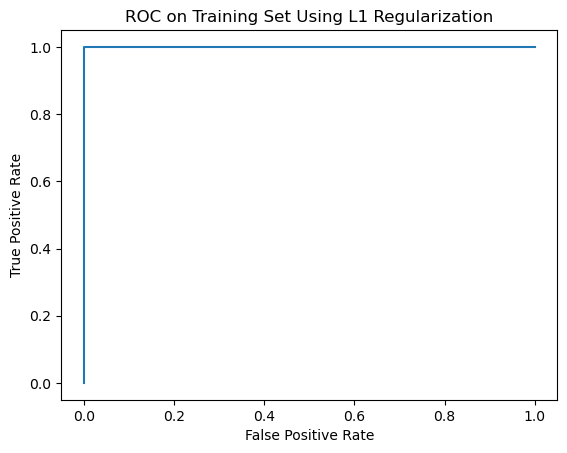

In [45]:
# ROC of training set
y_train_pred_proba = log_reg.predict_proba(X_train_pruned)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set Using L1 Regularization')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
# AUC of training set
auc_val = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val)

AUC: 1.0


In [47]:
# Parameters and p-values of the logistic regression
model = sm.Logit(y_train, X_train_pruned)
res = model.fit(method = 'lbfgs')
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.65185D+01

At iterate    1    f= -0.00000D+00    |proj g|=  5.82609D+00

At iterate    2    f= -0.00000D+00    |proj g|=  5.82609D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     24      2     0     0   5.826D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                           Logit Regression Results                   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [48]:
# Generate test instances
test_instances_with_break = breakAndExtract(paths, test_paths, best_pair_l1[0])
test_instances_with_break

Instance  Max_1     Mean_1  Median_1  Max_2    Mean_2  Median_2  Max_3  \
0          1  42.33  41.362563    42.000   1.22  0.256125     0.000  24.00   
1          2  44.25  42.921750    43.000   0.94  0.468438     0.500  25.33   
2          8  27.00  22.609937    23.750   6.76  0.871188     0.500  24.75   
3          9  30.00  28.792875    29.250   0.94  0.211625     0.000  24.00   
4         14  44.50  36.794750    35.875   8.18  2.459813     2.085  26.75   
5         15  44.00  37.521812    37.000   8.95  2.156500     1.790  21.50   
6         16  44.67  38.028875    36.750  12.99  2.005125     1.300  24.00   
7         29  29.75  27.788063    27.250   1.48  0.234312     0.000  11.75   
8         30  48.25  36.541562    30.000   3.11  0.291875     0.000  16.50   
9         31  48.00  48.000000    48.000   0.00  0.000000     0.000   9.25   
10        44  44.00  42.312125    42.000   1.12  0.294250     0.430  20.75   
11        45  50.75  45.949312    45.250   4.87  0.213687     0.000  24.00   
12        46  46.75  45.588875    45.500   1.00  0.349562     0.430  23.75   
13        59  47.67  46.242375    46.500   1.12  0.435750     0.500  18.75   
14        60  45.00  42.346687    42.875   2.12  0.543750     0.500  18.00   
15        61  46.50  44.595250    45.000   1.73  0.435312     0.470  19.25   
16        74  42.50  34.561437    36.000  12.19  4.017562     3.670  23.00   
17        75  43.00  33.666500    34.500  12.32  4.547250     4.070  23.75   
18        76  43.33  33.364562    34.000  12.00  4.637000     4.430  23.25   

       Mean_3  Median_3  ...  Max_16   Mean_16  Median_16  Max_17    Mean_17  \
0   18.327063    18.750  ...    5.50  1.006313      0.710   38.25  33.048812   
1   19.926937    20.500  ...    5.72  1.077813      0.830   36.67  31.673500   
2   19.152000    19.500  ...    6.76  0.802563      0.470   24.00  20.327687   
3   19.547875    20.290  ...    4.76  1.114875      0.830   33.00  16.303937   
4   17.569313    17.585  ...    7.43  2.622813      2.450   24.33  19.690750   
5   16.079688    16.290  ...    7.69  2.830063      2.650   24.33  19.839250   
6   16.356875    16.790  ...    9.74  3.019625      2.870   21.33  15.377875   
7    6.048563     6.710  ...    5.02  0.804500      0.500   17.00   7.138562   
8    6.689250     6.290  ...    0.94  0.291875      0.430    4.50   1.894750   
9    5.611250     6.000  ...    2.12  0.410750      0.430   12.00  10.496063   
10  16.353687    17.250  ...    5.36  0.803375      0.470   28.00  16.420938   
11  13.693937    15.000  ...    4.58  0.754562      0.470   22.00  17.938250   
12  14.673250    14.625  ...    6.36  0.947813      0.825   22.00  19.352688   
13  11.499125    12.000  ...    4.76  0.478250      0.430   18.25  10.264500   
14  13.899375    14.750  ...    3.00  0.566250      0.470   21.25  16.143313   
15  13.974312    15.000  ...    5.85  0.592938      0.430   21.00  13.510125   
16  15.881688    16.000  ...    8.86  3.222750      2.930   25.25  16.588812   
17  15.615375    15.900  ...    7.40  3.391250      3.180   24.25  17.053812   
18  15.464063    15.500  ...    7.22  3.059813      2.785   24.00  16.147875   

    Median_17  Max_18   Mean_18  Median_18  activity  
0      32.625    1.87  0.508875      0.430   bending  
1      31.500    2.62  0.402375      0.430   bending  
2      20.585    4.97  0.834563      0.710   bending  
3      14.875    6.76  1.715125      1.300   bending  
4      20.250    9.34  2.757938      2.360     other  
5      20.330    8.83  2.668250      2.175     other  
6      15.625    8.50  3.578813      3.350     other  
7       6.710    3.30  0.779438      0.820     other  
8       2.000    1.50  0.434250      0.470     other  
9      10.415    1.30  0.671625      0.730     other  
10     16.125    5.85  1.123750      0.830     other  
11     19.000    7.22  1.157813      0.830     other  
12     20.500    3.49  0.588250      0.430     other  
13      9.415    3.27  0.830313      0.820     other  
14     16.250    

In [49]:
# Test the model
test_instances_with_break = pd.get_dummies(test_instances_with_break, columns = ['activity'], drop_first = True)
X_test = test_instances_with_break[selected_l1]
X_test = sm.add_constant(X_test)
y_test = test_instances_with_break['activity_other']

y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy on test set:', accuracy)

accuracy on test set: 1.0


In [50]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[ 4  0]
 [ 0 15]]


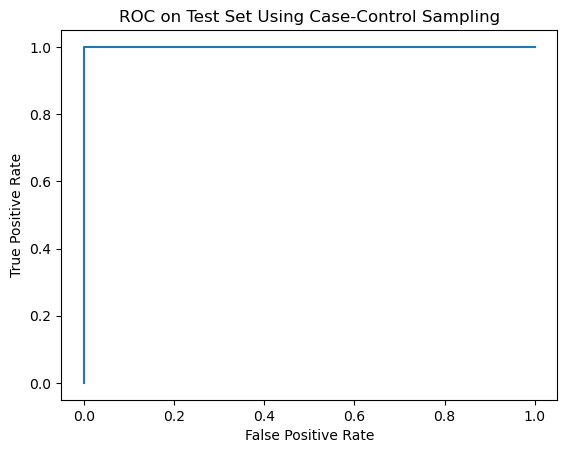

In [51]:
# ROC of test set
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Test Set Using Case-Control Sampling')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
# AUC of test set
auc_val = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_val)

AUC: 1.0


### 2. (b) ii. Compare the L1-penalized with variable selection using RFECV

It seems that both perform well as both confusion matrices indicates zero false positive and zero false negative, and the accuracies are all 1.0. In terms of coding, both are easy to implement. However, L1-penalized tends to take a longer time to execute, and it might be caused by the cross validation process for lambda.

## 2. (c) Multi-class Classification

### 2. (c) i. Build an L1-penalized multinomial regression model

In [53]:
# Define a function for extraction with different l
def breakAndExtractMultiClass(paths, train_paths, l):
    train_instances_with_break = None
    for i in range(len(train_paths)):
        df = pd.read_csv(train_paths[i], skiprows = 4)
        df = breakTimeSeries(df, l)
        stats = extractThreeFeatures(df, paths.index(train_paths[i]) + 1)
        if 'bending' in train_paths[i]:
            stats['activity'] = 'bending'
        elif 'cycling' in train_paths[i]:
            stats['activity'] = 'cycling'
        elif 'lying' in train_paths[i]:
            stats['activity'] = 'lying'
        elif 'sitting' in train_paths[i]:
            stats['activity'] = 'sitting'
        elif 'standing' in train_paths[i]:
            stats['activity'] = 'standing'
        elif 'walking' in train_paths[i]:
            stats['activity'] = 'walking'
        train_instances_with_break = pd.concat([train_instances_with_break, stats])

    train_instances_with_break = train_instances_with_break.reset_index(drop = True)
    return train_instances_with_break

In [54]:
# Fit a L1-penalized multinomial logistic regression model
cv_scores_multi = []
# pairs_multi = []
ls_multi = []
l = 1
while l <= 20:
    train_instances_with_break = breakAndExtractMultiClass(paths, train_paths, l)
    X_train = train_instances_with_break.iloc[:, 1:-1]
    y_train = train_instances_with_break['activity']
    
    log_reg = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'saga', refit = True, multi_class = 'multinomial', random_state = 42)
    log_reg = log_reg.fit(X_train, y_train)
    
    cv_score = log_reg.score(X_train, y_train)
    cv_scores_multi.append(cv_score)
    
    ls_multi.append(l)

    l += 1

In [55]:
# Find the best l with the highest cv score
for i in range(len(cv_scores_multi)):
    if cv_scores_multi[i] == max(cv_scores_multi):
        best_l_multi = ls_multi[i]
        break

print('best l:', best_l_multi)

best l: 5


In [56]:
# Refit a logistic regression model
train_instances_with_break = breakAndExtractMultiClass(paths, train_paths, best_l_multi)
X_train = train_instances_with_break.iloc[:, 1:-1]
X_train = sm.add_constant(X_train)
y_train = train_instances_with_break['activity']

log_reg = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'saga', refit = True, multi_class = 'multinomial', random_state = 42)
log_reg = log_reg.fit(X_train, y_train)

In [57]:
# Confusion matrix of training set
y_train_pred = log_reg.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


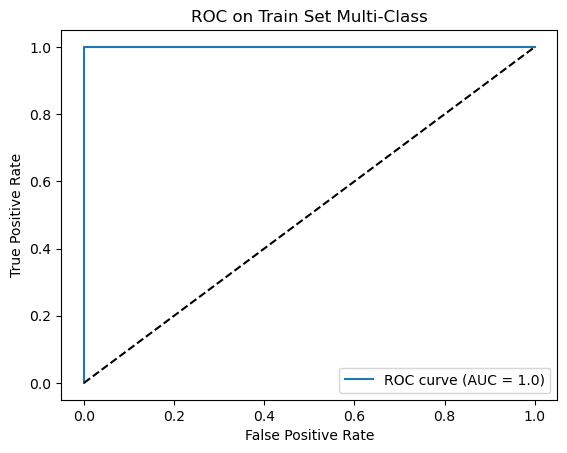

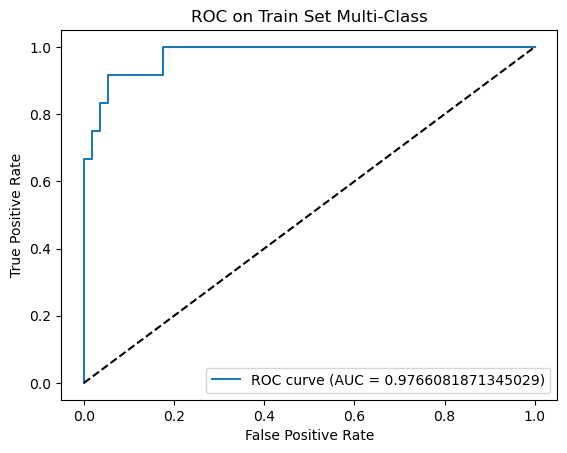

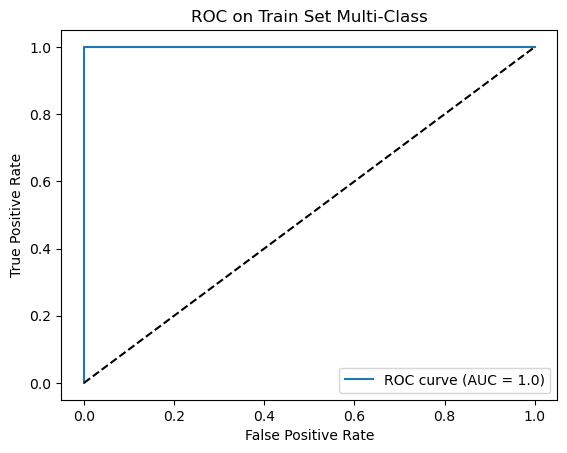

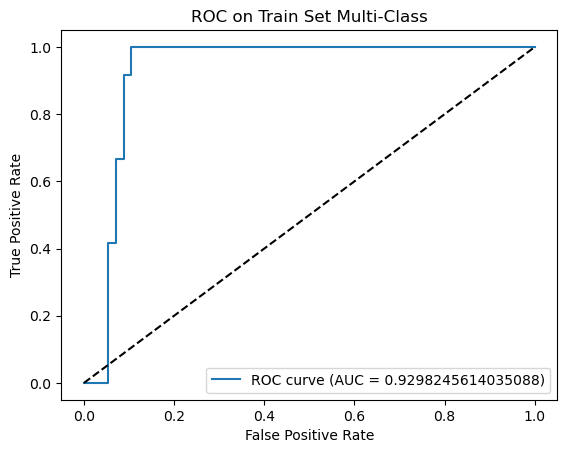

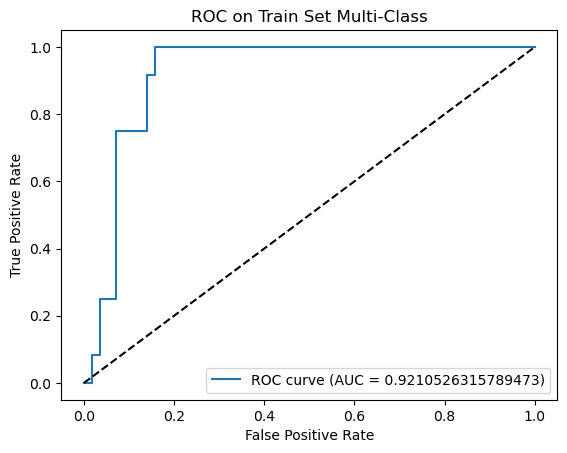

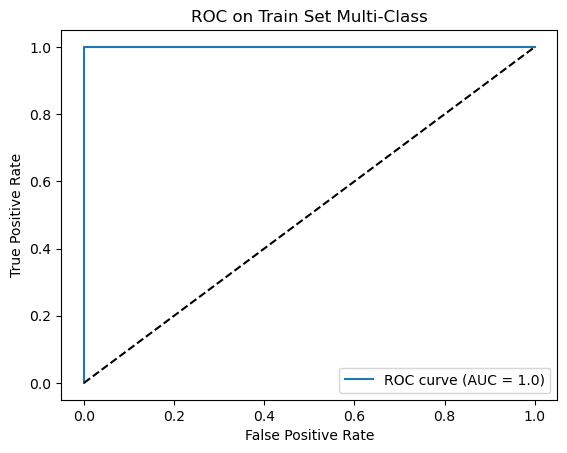

In [58]:
# ROC of training set
def generate(classes, y_true, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

def plotTrain(fpr, tpr, roc_auc):
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], label = 'ROC curve (AUC = ' + str(roc_auc[i]) + ')')
        plt.title('ROC on Train Set Multi-Class')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend(loc = "lower right")
        plt.show()

classes = len(log_reg.classes_)
y_train = pd.get_dummies(y_train, drop_first = False).values
y_train_score = log_reg.decision_function(X_train)

fpr, tpr, roc_auc = generate(classes, y_train, y_train_score)
plotTrain(fpr, tpr, roc_auc)

In [59]:
# Test the model
test_instances_with_break = breakAndExtractMultiClass(paths, test_paths, best_l_multi)
X_test = test_instances_with_break.iloc[:, 1:-1]
X_test = sm.add_constant(X_test)
y_test = test_instances_with_break['activity']

y_pred = log_reg.predict(X_test)
error = 1 - accuracy_score(y_test, y_pred)

print('test error:', error)

test error: 0.10526315789473684


In [60]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[3 1 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


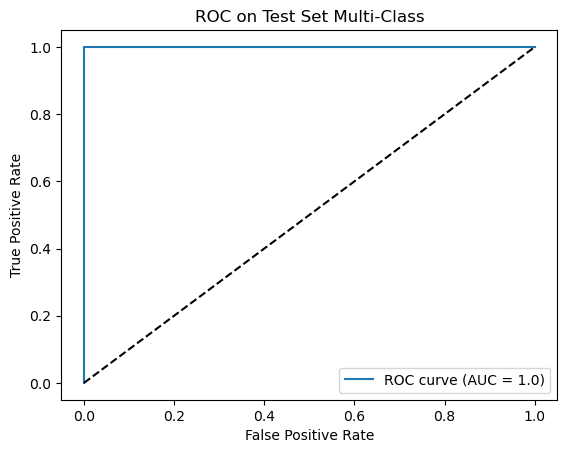

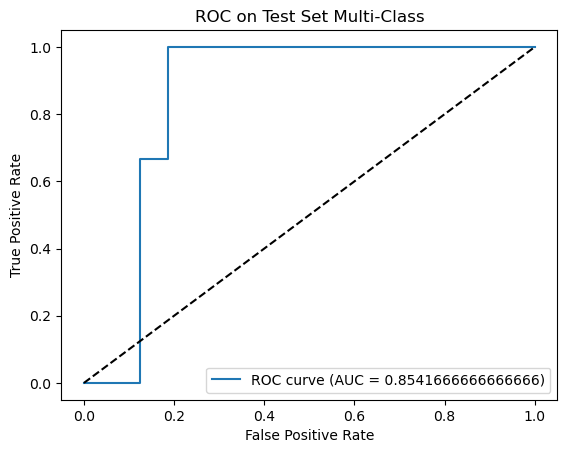

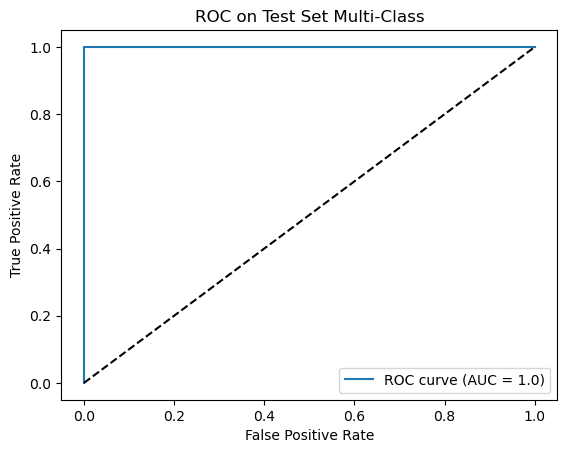

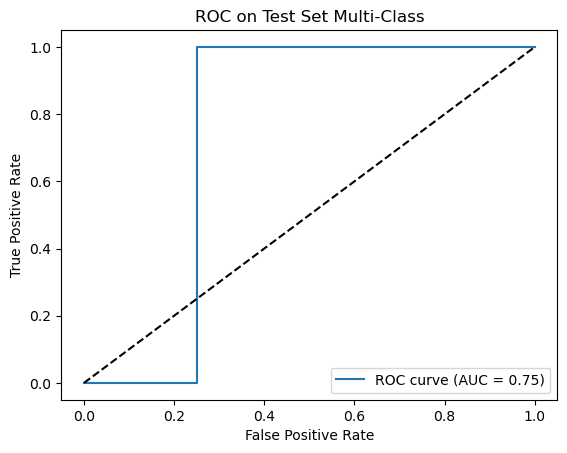

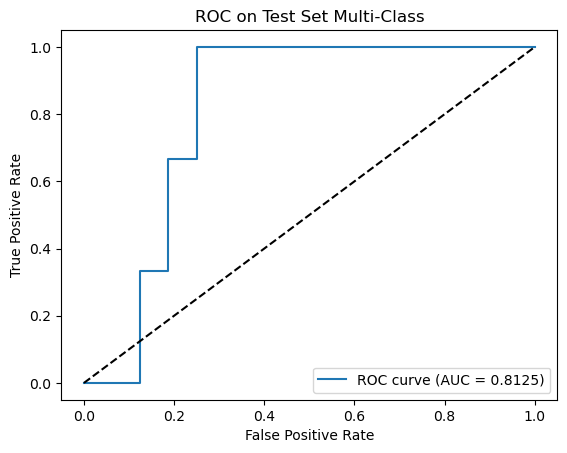

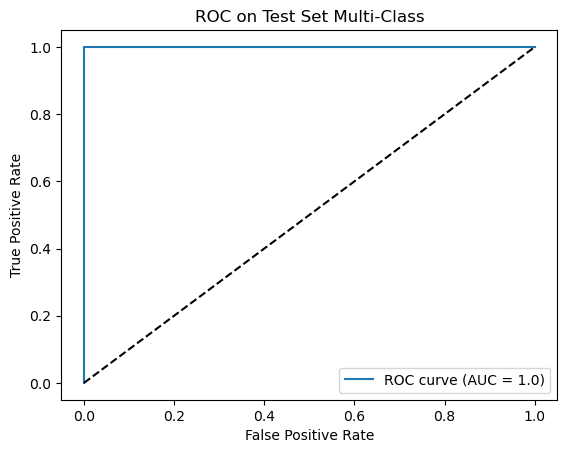

In [61]:
# ROC of test set
def plotTest(fpr, tpr, roc_auc):
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], label = 'ROC curve (AUC = ' + str(roc_auc[i]) + ')')
        plt.title('ROC on Test Set Multi-Class')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend(loc = "lower right")
        plt.show()

y_test = pd.get_dummies(y_test, drop_first = False).values
y_score = log_reg.decision_function(X_test)

fpr, tpr, roc_auc = generate(classes, y_test, y_score)
plotTest(fpr, tpr, roc_auc)

### 2. (c) ii. Naive Bayes’ classifier

In [62]:
# Fit a Naive Bayers Gaussian model
scores_gaussianNB = []
ls_gaussianNB = []
l = 1
while l <= 20:
    train_instances_with_break = breakAndExtractMultiClass(paths, train_paths, l)
    X_train = train_instances_with_break.iloc[:, 1:-1]
    y_train = train_instances_with_break['activity']
    
    model = GaussianNB()
    gaussianNB = model.fit(X_train, y_train)
    
    score = gaussianNB.score(X_train, y_train)
    scores_gaussianNB.append(score)
    
    ls_gaussianNB.append(l)

    l += 1

In [63]:
# Find the best l with the highest score
for i in range(len(scores_gaussianNB)):
    if scores_gaussianNB[i] == max(scores_gaussianNB):
        best_l_gaussianNB = ls_gaussianNB[i]
        break

print('best l:', best_l_gaussianNB)

best l: 20


In [64]:
# Refit a Naive Bayers Gaussian model
train_instances_with_break = breakAndExtractMultiClass(paths, train_paths, best_l_gaussianNB)
X_train = train_instances_with_break.iloc[:, 1:-1]
X_train = sm.add_constant(X_train)
y_train = train_instances_with_break['activity']

gaussianNB = GaussianNB()
gaussianNB = gaussianNB.fit(X_train, y_train)

In [65]:
# Confusion matrix of training set
y_train_pred = gaussianNB.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


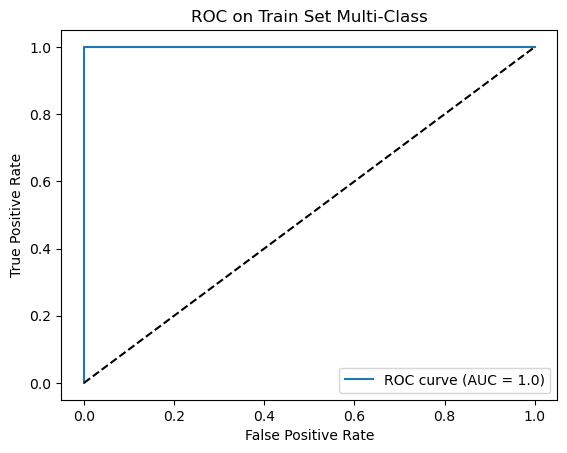

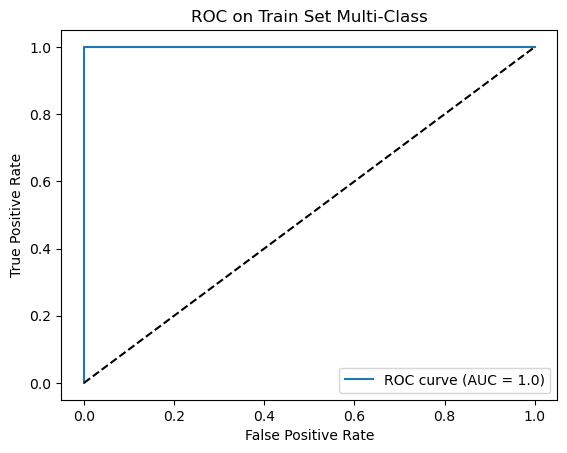

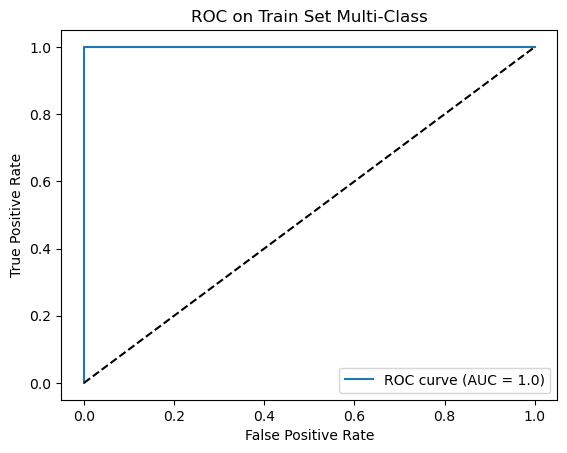

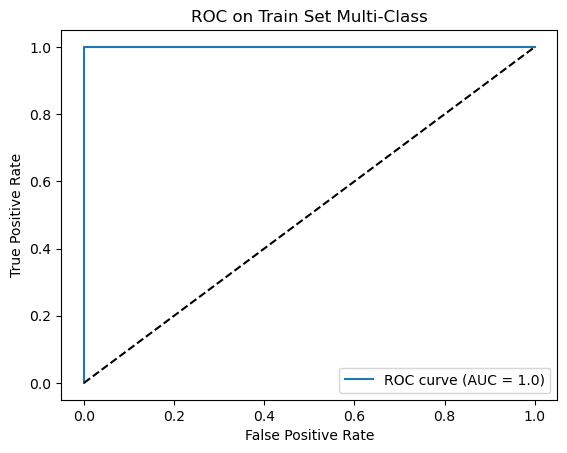

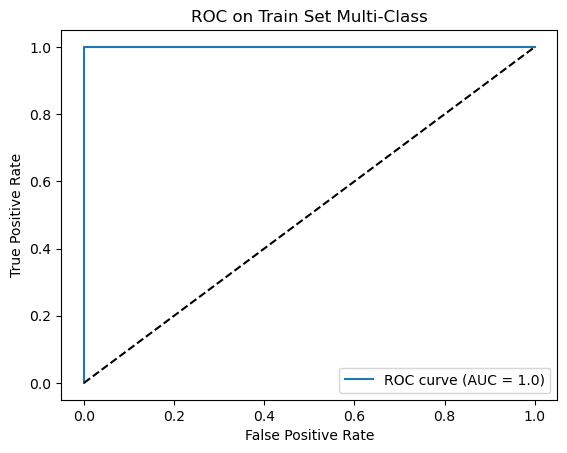

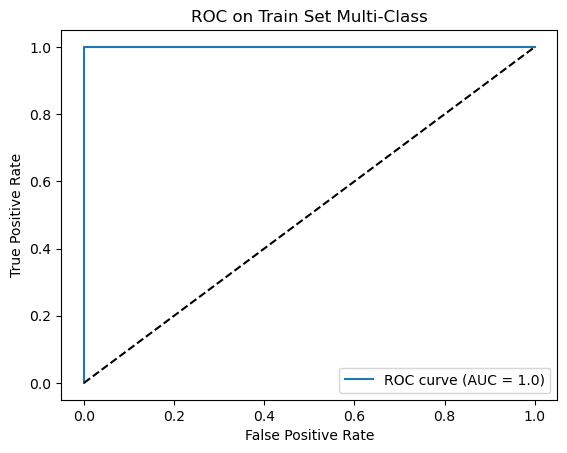

In [66]:
# ROC of training set
classes = len(gaussianNB.classes_)
y_train = pd.get_dummies(y_train, drop_first = False).values
y_train_score = gaussianNB.predict_proba(X_train)

fpr, tpr, roc_auc = generate(classes, y_train, y_train_score)
plotTrain(fpr, tpr, roc_auc)

In [67]:
# Test the model
test_instances_with_break = breakAndExtractMultiClass(paths, test_paths, best_l_gaussianNB)
X_test = test_instances_with_break.iloc[:, 1:-1]
X_test = sm.add_constant(X_test)
y_test = test_instances_with_break['activity']

y_pred = gaussianNB.predict(X_test)
error = 1 - accuracy_score(y_test, y_pred)

print('test error:', error)

test error: 0.10526315789473684


In [68]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


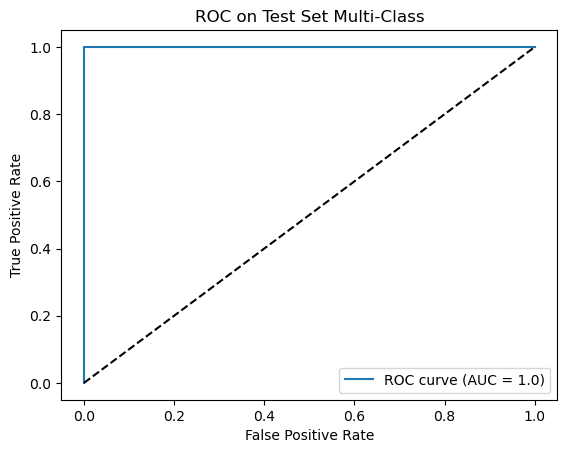

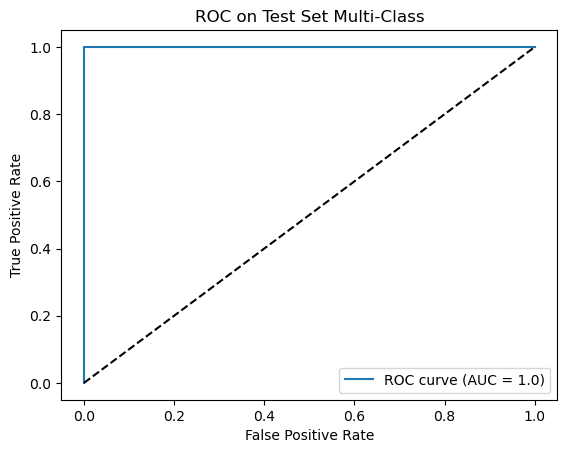

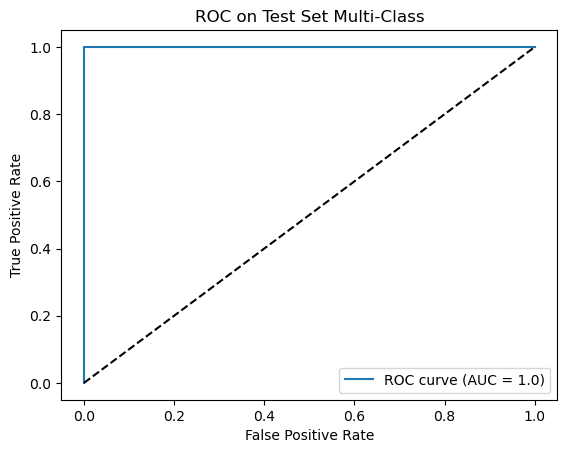

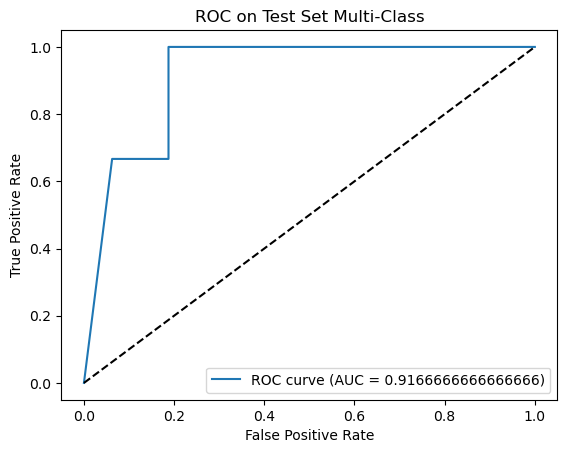

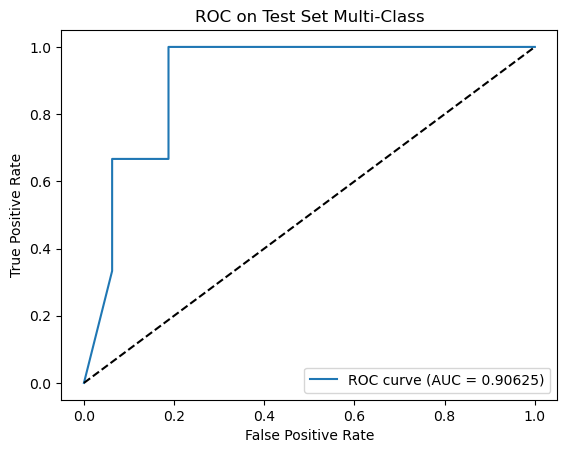

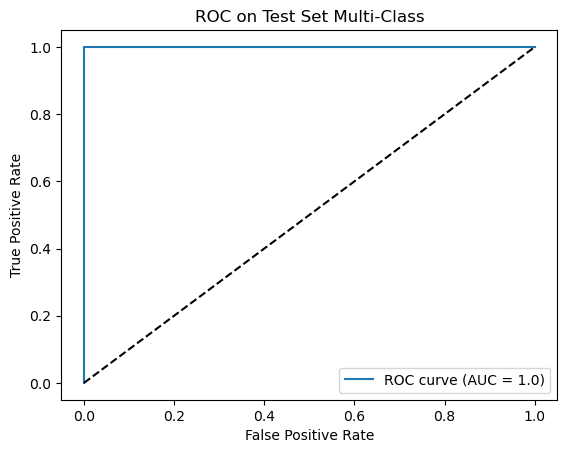

In [69]:
# ROC of test set
y_test = pd.get_dummies(y_test, drop_first = False).values
y_score = gaussianNB.predict_proba(X_test)

fpr, tpr, roc_auc = generate(classes, y_test, y_score)
plotTest(fpr, tpr, roc_auc)

In [70]:
# Fit a Naive Bayers Multinomial model
scores_multiNB = []
ls_multiNB = []
l = 1
while l <= 20:
    train_instances_with_break = breakAndExtractMultiClass(paths, train_paths, l)
    X_train = train_instances_with_break.iloc[:, 1:-1]
    y_train = train_instances_with_break['activity']
    
    model = MultinomialNB()
    multiNB = model.fit(X_train, y_train)
    
    score = multiNB.score(X_train, y_train)
    scores_multiNB.append(score)
    
    ls_multiNB.append(l)

    l += 1

In [71]:
# Find the best l with the highest score
for i in range(len(scores_multiNB)):
    if scores_multiNB[i] == max(scores_multiNB):
        best_l_multiNB = ls_multiNB[i]
        break

print('best l:', best_l_multiNB)

best l: 3


In [72]:
# Refit a Naive Bayers Multinomial model
train_instances_with_break = breakAndExtractMultiClass(paths, train_paths, best_l_multiNB)
X_train = train_instances_with_break.iloc[:, 1:-1]
X_train = sm.add_constant(X_train)
y_train = train_instances_with_break['activity']

multiNB = MultinomialNB()
multiNB = multiNB.fit(X_train, y_train)

In [73]:
# Confusion matrix of training set
y_train_pred = multiNB.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  0 11  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


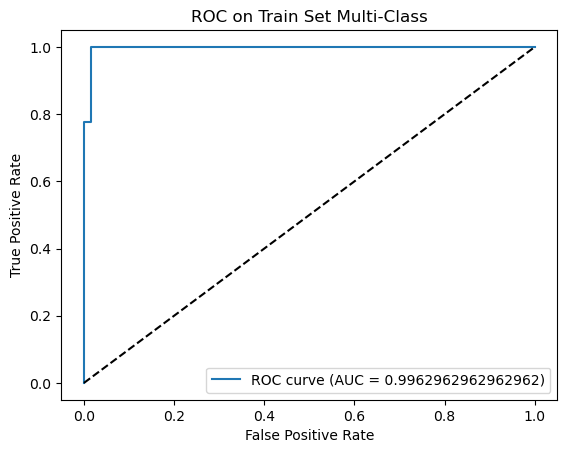

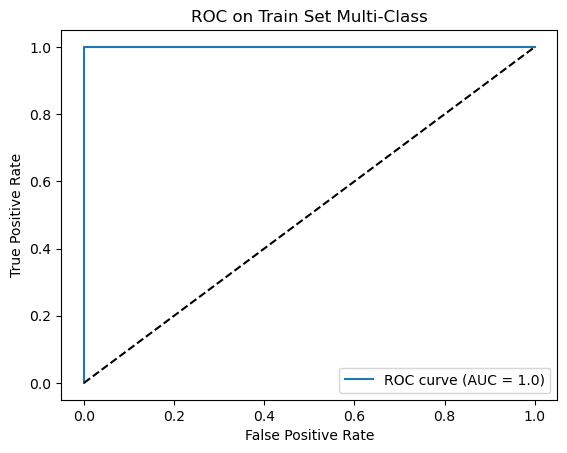

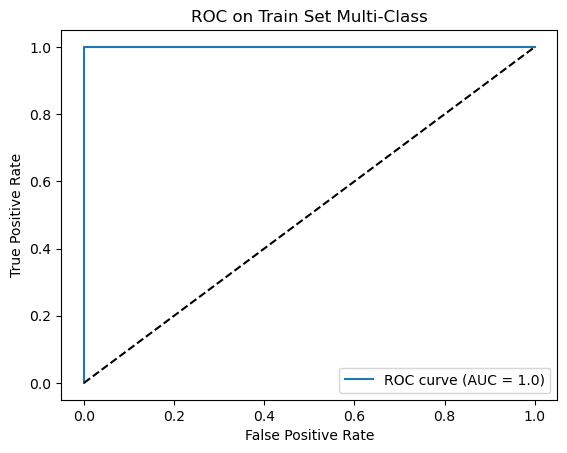

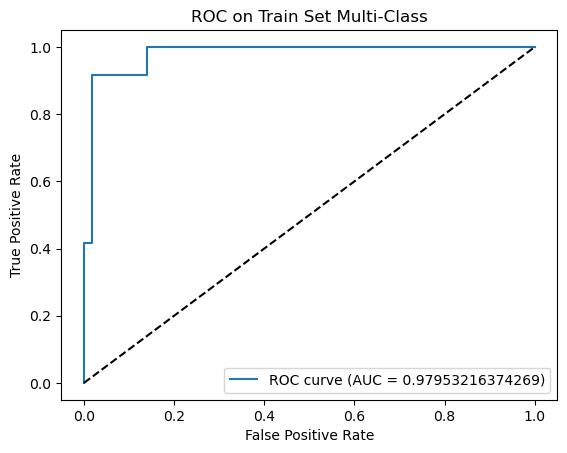

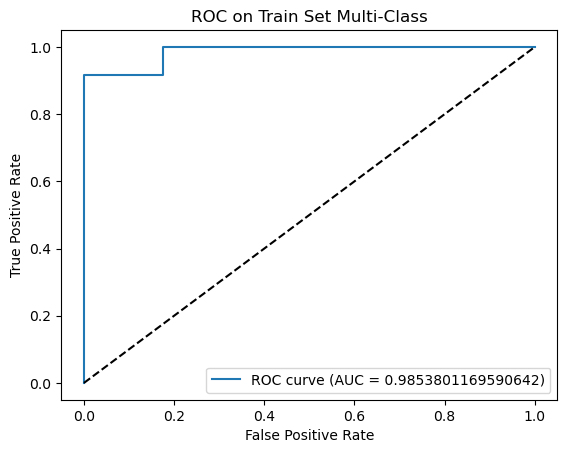

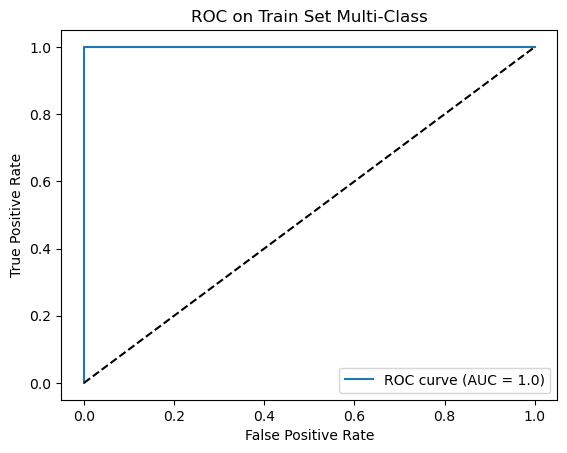

In [74]:
# ROC of training set
classes = len(multiNB.classes_)
y_train = pd.get_dummies(y_train, drop_first = False).values
y_train_score = multiNB.predict_proba(X_train)

fpr, tpr, roc_auc = generate(classes, y_train, y_train_score)
plotTrain(fpr, tpr, roc_auc)

In [75]:
# Test the model
test_instances_with_break = breakAndExtractMultiClass(paths, test_paths, best_l_multiNB)
X_test = test_instances_with_break.iloc[:, 1:-1]
X_test = sm.add_constant(X_test)
y_test = test_instances_with_break['activity']

y_pred = multiNB.predict(X_test)
error = 1 - accuracy_score(y_test, y_pred)

print('test error:', error)

test error: 0.052631578947368474


In [76]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


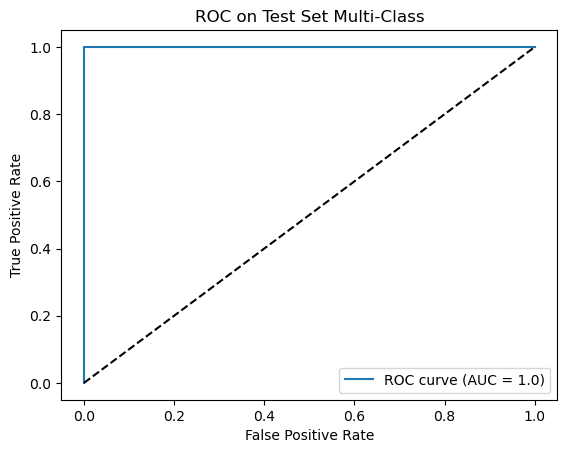

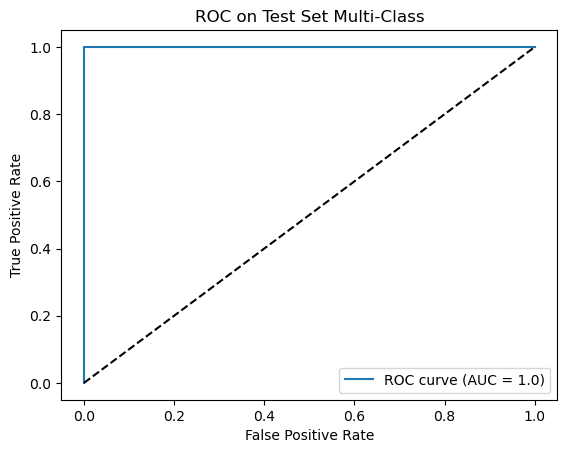

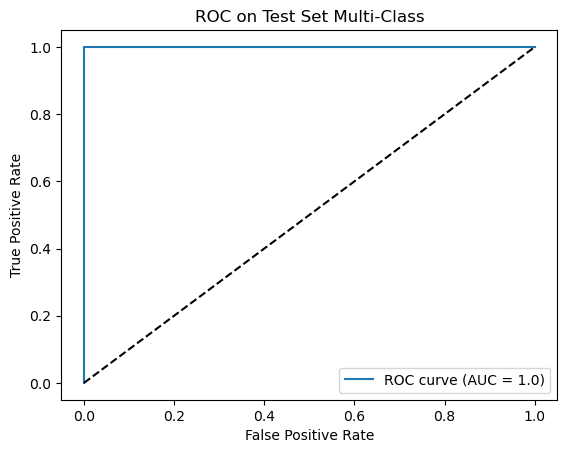

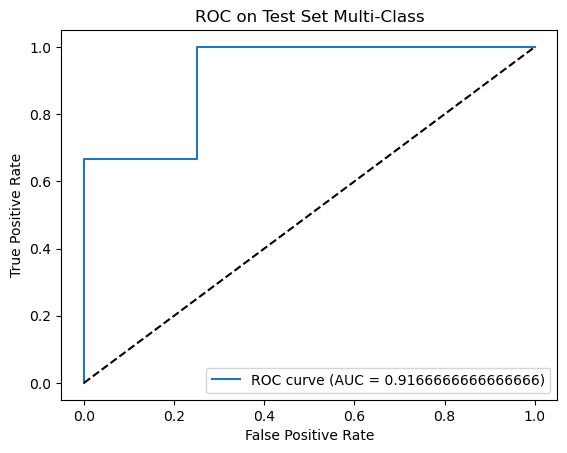

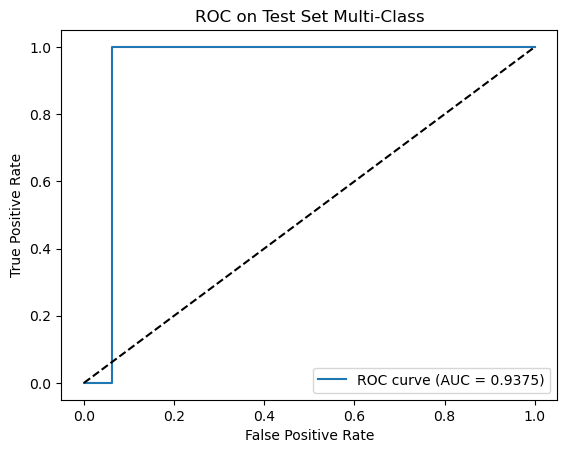

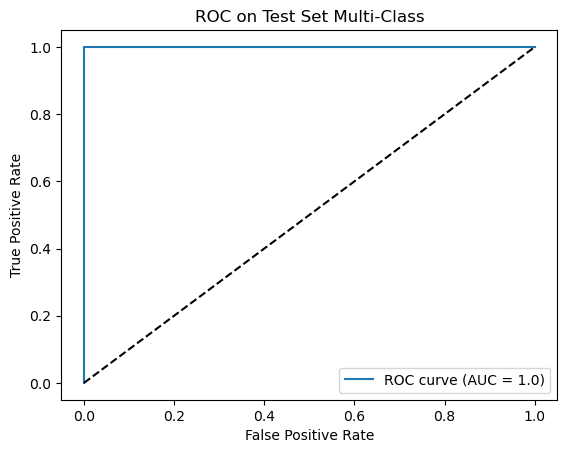

In [77]:
# ROC of test set
y_test = pd.get_dummies(y_test, drop_first = False).values
y_score = multiNB.predict_proba(X_test)

fpr, tpr, roc_auc = generate(classes, y_test, y_score)
plotTest(fpr, tpr, roc_auc)

### 2. (c) iii. Best multi-class classification model?

The L1-penalized multinomial regression model and the Naive Bayes Gaussian model both give a test error of 0.10526315789473684, and the Naive Bayes Multinomial model gives a test error of 0.052631578947368474. Therefore, the Naive Bayes Multinomial model seems to give the best performance for multi-class classification in this problem.

# 3. ISLR 4.8.3

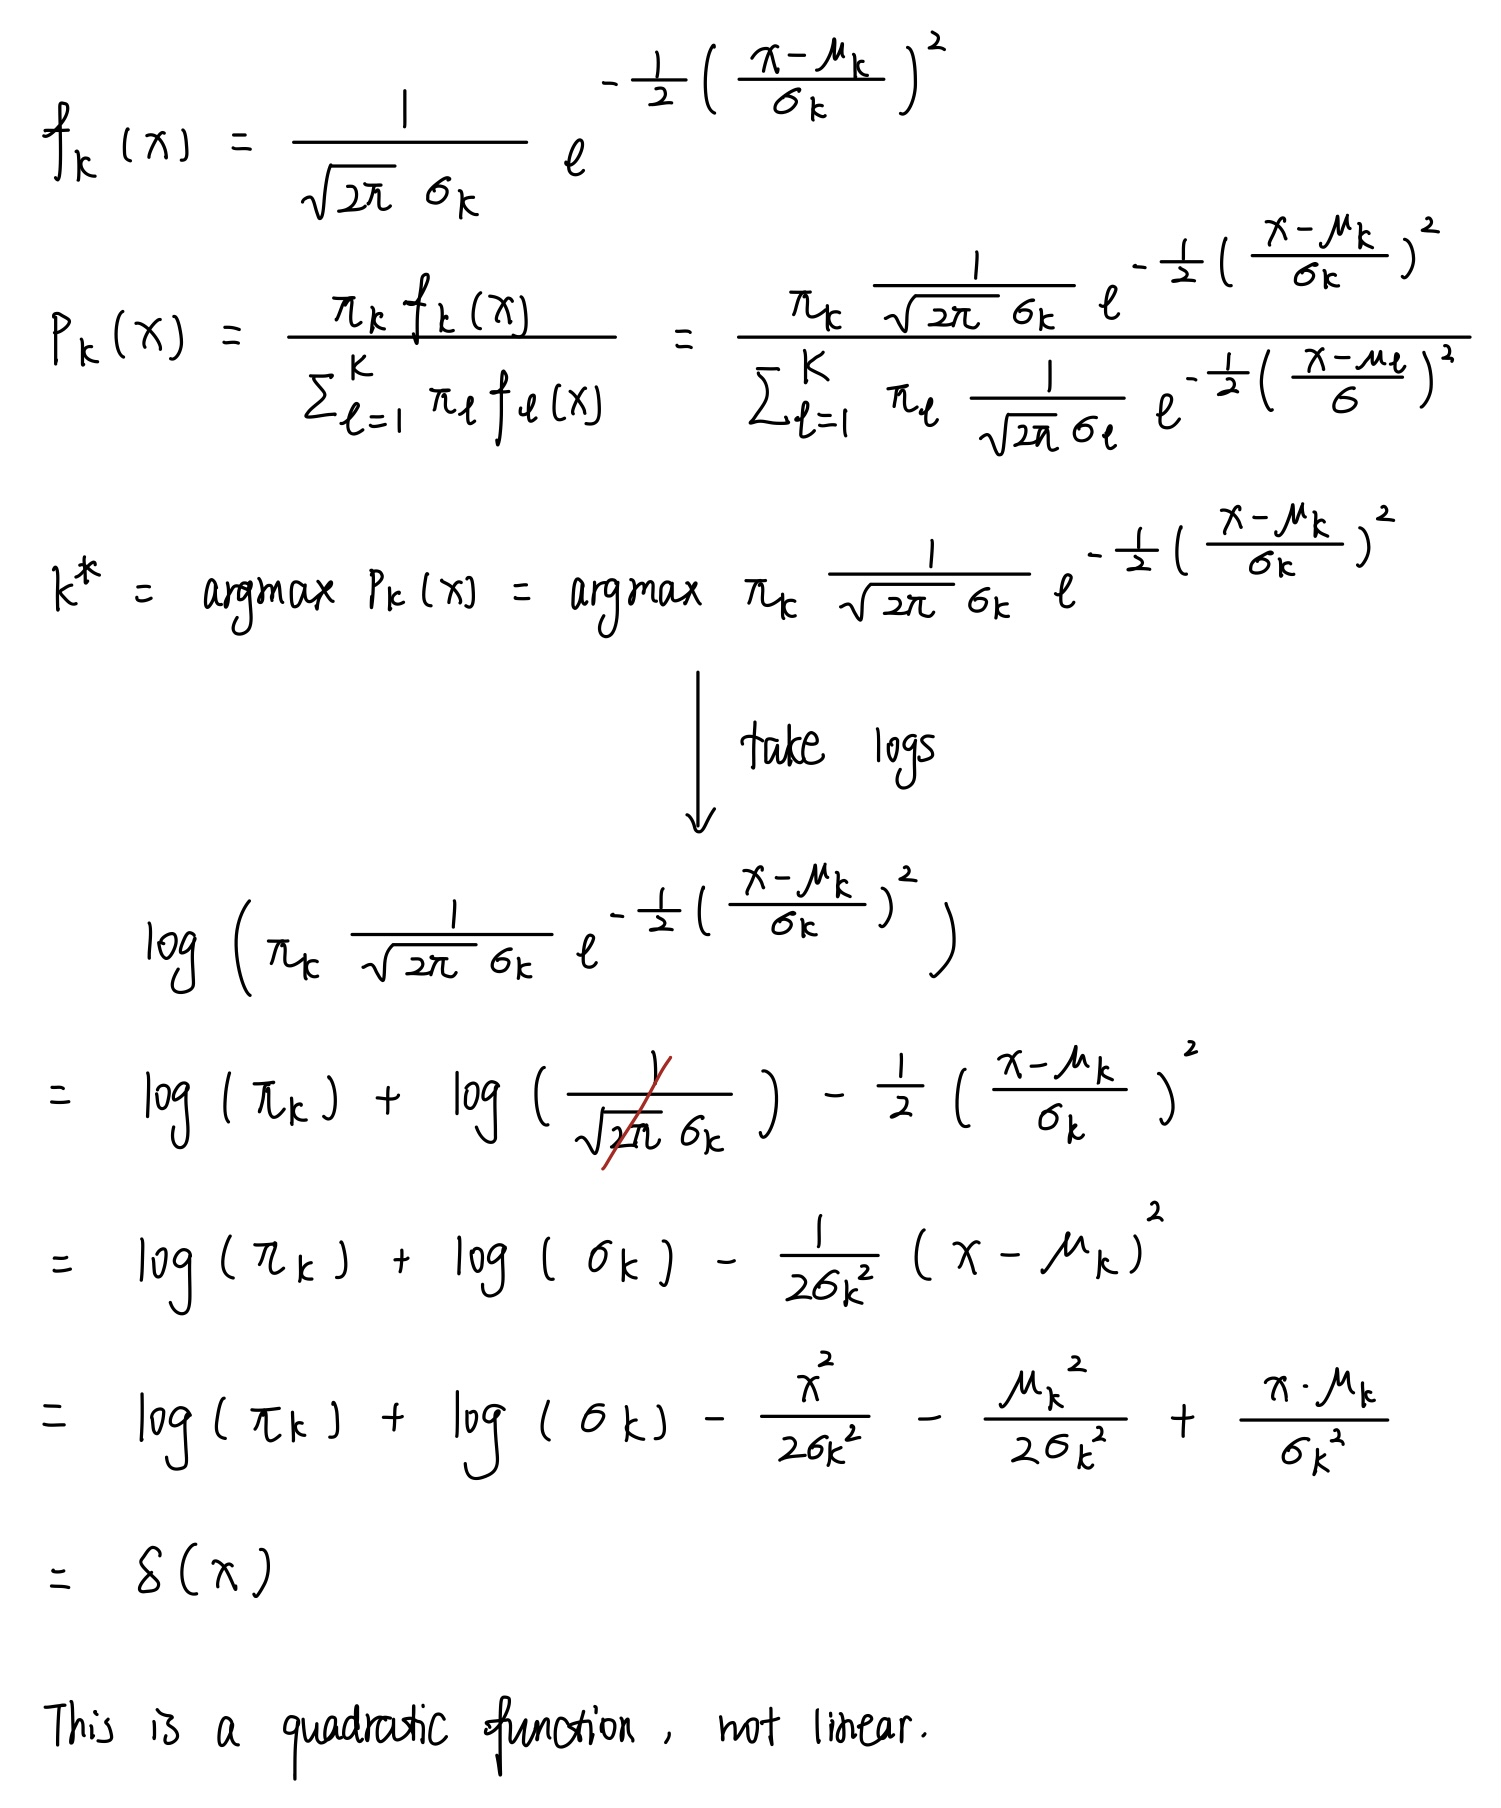

# 4. ISLR 4.8.7

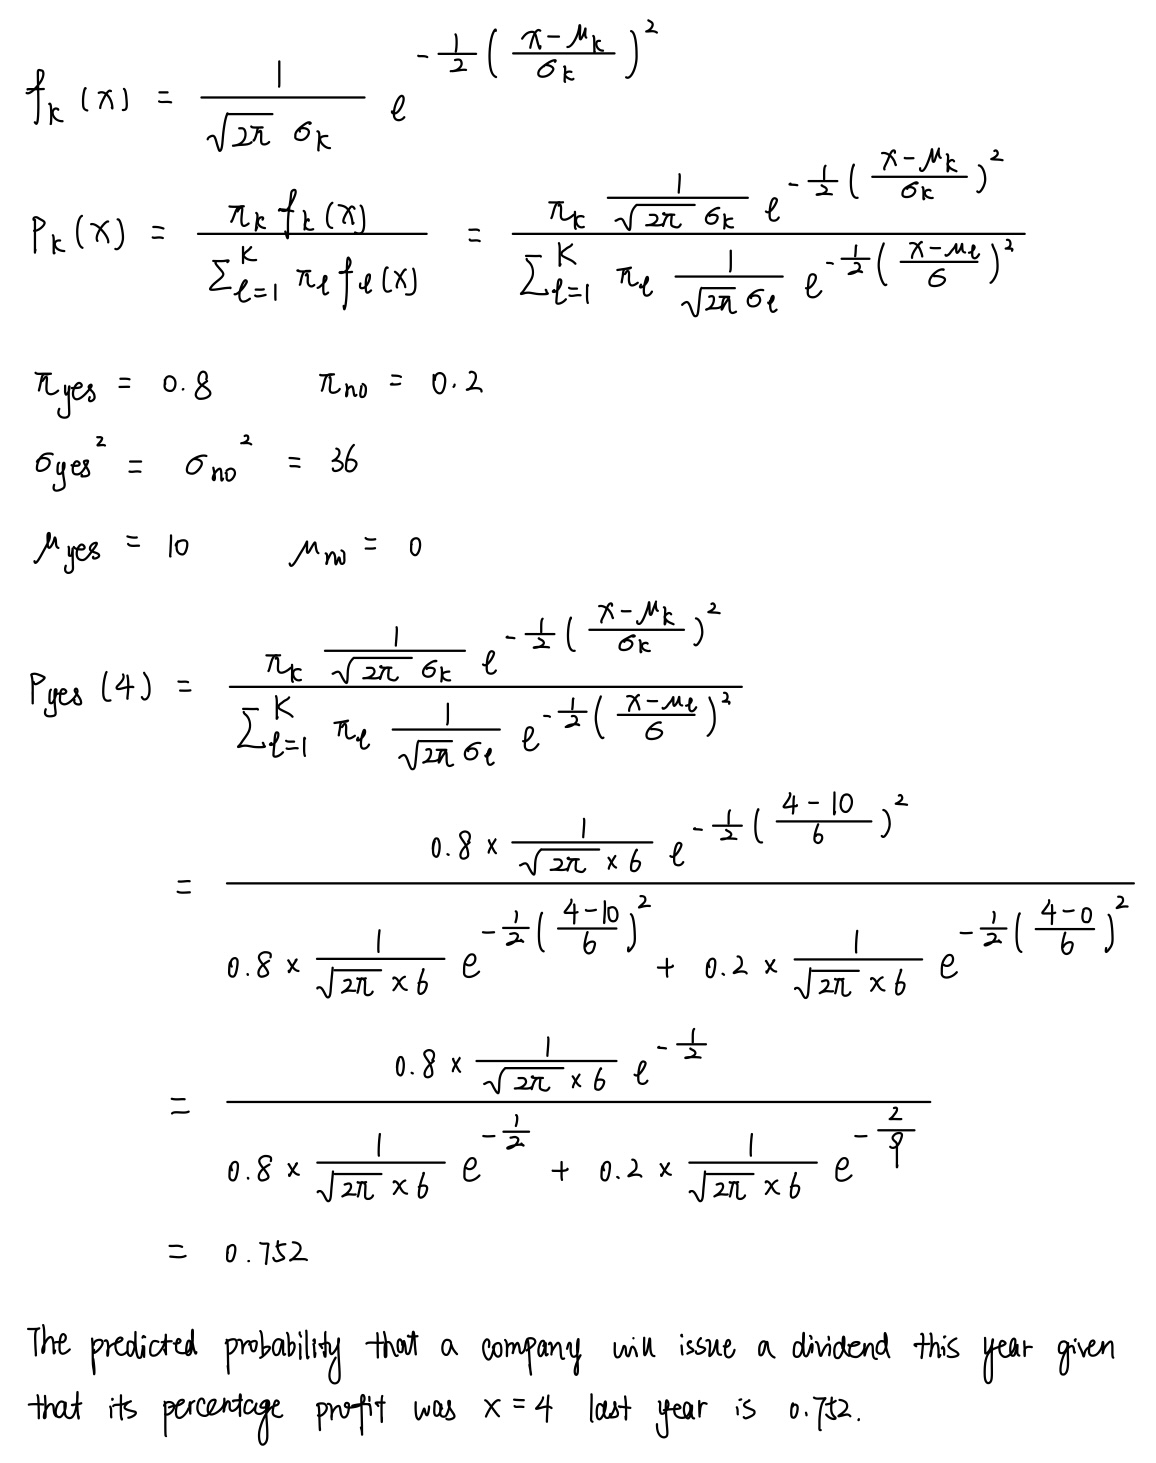